<a href="https://colab.research.google.com/github/trndnhan/Facial-Deepfake-Detection-with-ViT-and-CNN/blob/main/Thesis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library install & import

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from PIL import Image
from transformers import AutoImageProcessor, Trainer, ViTForImageClassification, TrainingArguments, TrainerCallback, ResNetForImageClassification
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
from peft import LoraConfig, get_peft_model

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Data exploration

In [ ]:
def count_files_in_subfolders(base_folder):
    """
    Counts and prints the number of files in each subfolder of the specified base folder.

    Parameters:
    base_folder (str): The path to the base folder containing subfolders.

    This function iterates through each subfolder within the base folder,
    counts the number of files in each subfolder, and prints the result.
    It only considers directories within the base folder.
    """

    # Get a list of paths for all subdirectories in the base folder
    subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]

    # Iterate through each subfolder
    for subfolder in subfolders:
        # Count the number of files in the current subfolder
        num_files = len(os.listdir(subfolder))

        # Print the number of files in the current subfolder
        print(f"Folder {subfolder} contains {num_files} files")

In [ ]:
count_files_in_subfolders('data')

Folder data\test contains 2 files
Folder data\train contains 2 files
Folder data\valid contains 2 files


In [ ]:
count_files_in_subfolders('data/test')

Folder data/test\fake contains 10000 files
Folder data/test\real contains 10000 files


In [ ]:
count_files_in_subfolders('data/valid')

Folder data/valid\fake contains 10000 files
Folder data/valid\real contains 10000 files


In [ ]:
count_files_in_subfolders('data/train')

Folder data/train\fake contains 50000 files
Folder data/train\real contains 50000 files


In [ ]:
# Function to load the first N images from a given directory
def load_sample_images(base_folder, num_images=4):
    """
    Loads the first N image files from a specified directory.

    Parameters:
    base_folder (str): The path to the directory containing images.
    num_images (int): The number of images to load from the directory (default is 4).

    Returns:
    list: A list of paths to the first N image files found in the directory.
    If the directory does not exist or contains fewer than N images, returns a list with fewer images or an empty list.
    """
    # Check if the specified directory exists
    if not os.path.exists(base_folder):
        print(f"Directory {base_folder} does not exist.")
        return []

    # Get a list of image files in the base folder that match the specified formats
    images = [os.path.join(base_folder, img) for img in os.listdir(base_folder)
              if img.lower().endswith(('png', 'jpg', 'jpeg'))]

    # Return the first num_images from the list of images
    return images[:num_images]  # Return the first num_images


# Function to display images
def display_images(images, labels):
    """
    Displays a set of images with corresponding labels.

    Parameters:
    images (list): A list of image file paths to be displayed.
    labels (list): A list of labels corresponding to each image for display.

    This function creates a grid layout to display images using Matplotlib,
    with titles for each image based on the provided labels. If an image fails to load,
    an error message is printed.
    """
    plt.figure(figsize=(12, 6))  # Set the figure size for the plot
    for i, (img_path, label) in enumerate(zip(images, labels)):
        try:
            img = Image.open(img_path)  # Open the image file
            plt.subplot(2, 4, i + 1)  # Create a subplot for each image
            plt.imshow(img)  # Display the image
            plt.title(label, fontsize=12)  # Set the title to the corresponding label
            plt.axis('off')  # Hide the axis for a cleaner look
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")  # Print error message if the image fails to load
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the figure

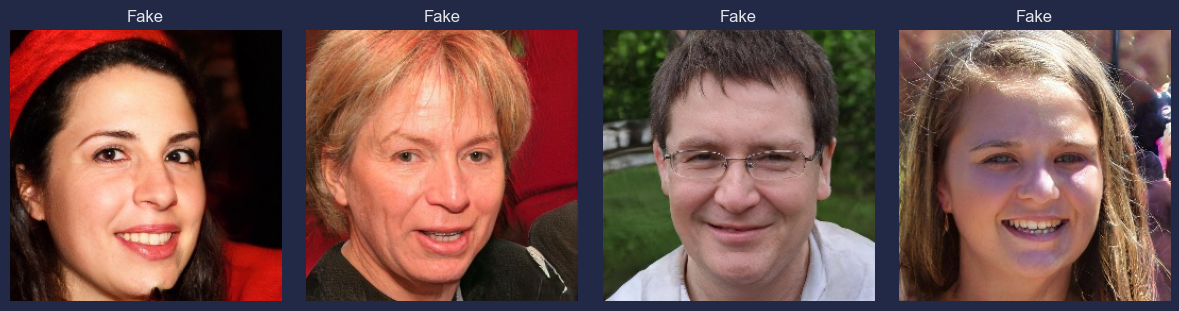

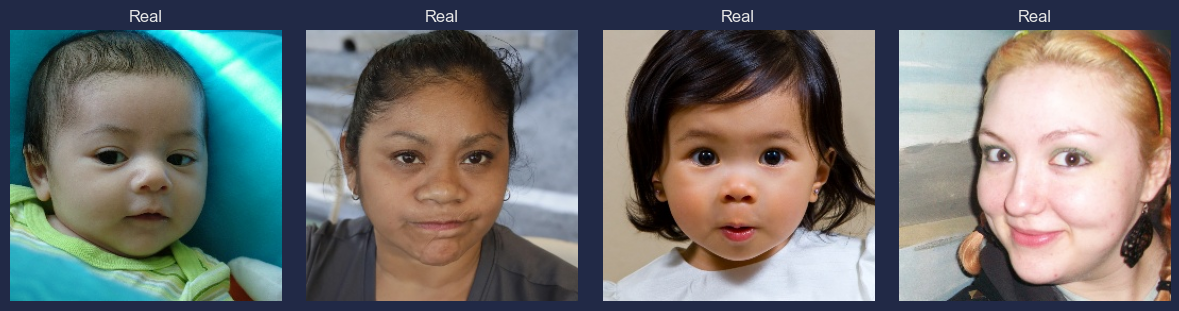

In [ ]:
# Define base folders for fake and real data
base_folder_fake = 'data/train/fake'
base_folder_real = 'data/train/real'

# Load the first 4 images
fake_images = load_sample_images(base_folder_fake, num_images=4)
real_images = load_sample_images(base_folder_real, num_images=4)

# Display images
if fake_images:  # Check if any fake images were loaded
    display_images(fake_images, ['Fake'] * len(fake_images))
if real_images:  # Check if any real images were loaded
    display_images(real_images, ['Real'] * len(real_images))

# Data preprocessing & augmentation

In [ ]:
base_vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
vit_model  = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_processor

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-st

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
base_rn_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True)
rn_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True)
rn_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
rn_processor

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [ ]:
# Shared augmentation pipeline
augmentation_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Color jitter
])

# Define the combined transform for ViT
train_vit_combined_transforms = transforms.Compose([
    augmentation_pipeline,  # Apply augmentations
    transforms.Lambda(lambda img: vit_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

val_test_vit_combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: vit_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

# Define the combined transform for ResNet
train_resnet_combined_transforms = transforms.Compose([
    augmentation_pipeline,  # Apply augmentations
    transforms.Lambda(lambda img: rn_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

val_test_resnet_combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: rn_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

In [ ]:
# Load the dataset
dataset = ImageFolder(root='data/train_subset5')

In [ ]:
print(f"Training set size: {len(dataset)}")

Training set size: 20000


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """
    A custom dataset class for handling image data and corresponding labels.
    This class wraps a given dataset and applies transformations to the images.

    Parameters:
        dataset (torch.utils.data.Dataset): The dataset containing the images and labels.
        transform (callable, optional): A function/transform to apply to the images.
    """

    def __init__(self, dataset, transform=None):
        # Store the dataset and the optional transformations
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the image and label for the given index
        img, label = self.dataset[idx]

        # Apply transformations if specified
        if self.transform:
            img = self.transform(img)

        # Return a dictionary containing the processed image and label
        return {"pixel_values": img, "labels": label}

# Wrap the datasets with the appropriate transforms
vit_train_dataset = CustomDataset(dataset, transform=train_vit_combined_transforms)

# Wrap the datasets with the appropriate transforms
rn_train_dataset = CustomDataset(dataset, transform=train_resnet_combined_transforms)

# Data after preprocessing

In [ ]:
# Function to fetch images by specific indices
def get_images_by_index(dataset, real_indices, fake_indices):
    """
    Fetches images from the dataset based on specified indices for real and fake classes.

    Parameters:
    - dataset: The complete dataset containing both real and fake images.
    - real_indices: List of indices to retrieve real images from the dataset.
    - fake_indices: List of indices to retrieve fake images from the dataset.

    Returns:
    - real_images: List of real images fetched from the dataset.
    - fake_images: List of fake images fetched from the dataset.
    """
    # Fetch real and fake images using the provided indices
    real_images = [dataset[i] for i in real_indices]
    fake_images = [dataset[i] for i in fake_indices]
    return real_images, fake_images


# Function to visualize images
def visualize_images(real_images, fake_images):
    """
    Visualizes a selection of real and fake images in a 2x4 grid.

    Parameters:
    - real_images: List of images labeled as 'real'.
    - fake_images: List of images labeled as 'fake'.
    """
    plt.figure(figsize=(16, 8))  # Set figure size for display

    # Visualize real images
    for i, sample in enumerate(real_images):
        img = sample['pixel_values']  # Extract pixel values from the sample
        plt.subplot(2, 4, i + 1)  # Position real images in the first row
        plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to array format for plotting
        plt.title('real')  # Label the image as 'real'
        plt.axis('off')  # Hide axis for a cleaner display

    # Visualize fake images
    for i, sample in enumerate(fake_images):
        img = sample['pixel_values']  # Extract pixel values from the sample
        plt.subplot(2, 4, i + 5)  # Position fake images in the second row
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title('fake')  # Label the image as 'fake'
        plt.axis('off')  # Hide axis for a cleaner display

    plt.show()  # Display the plotted images

In [ ]:
# Specify the indices for real and fake images
fake_indices = [0, 1, 2, 3]  # First 4 real images
real_indices = [50000, 50001, 50002, 50003]  # First 4 fake images (start at 50000)

# Get images from vit_train_dataset
vit_real_images, vit_fake_images = get_images_by_index(vit_train_dataset, real_indices, fake_indices)

# Get images from rn_train_dataset
rn_real_images, rn_fake_images = get_images_by_index(rn_train_dataset, real_indices, fake_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.36470592].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49019605..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.62352943]

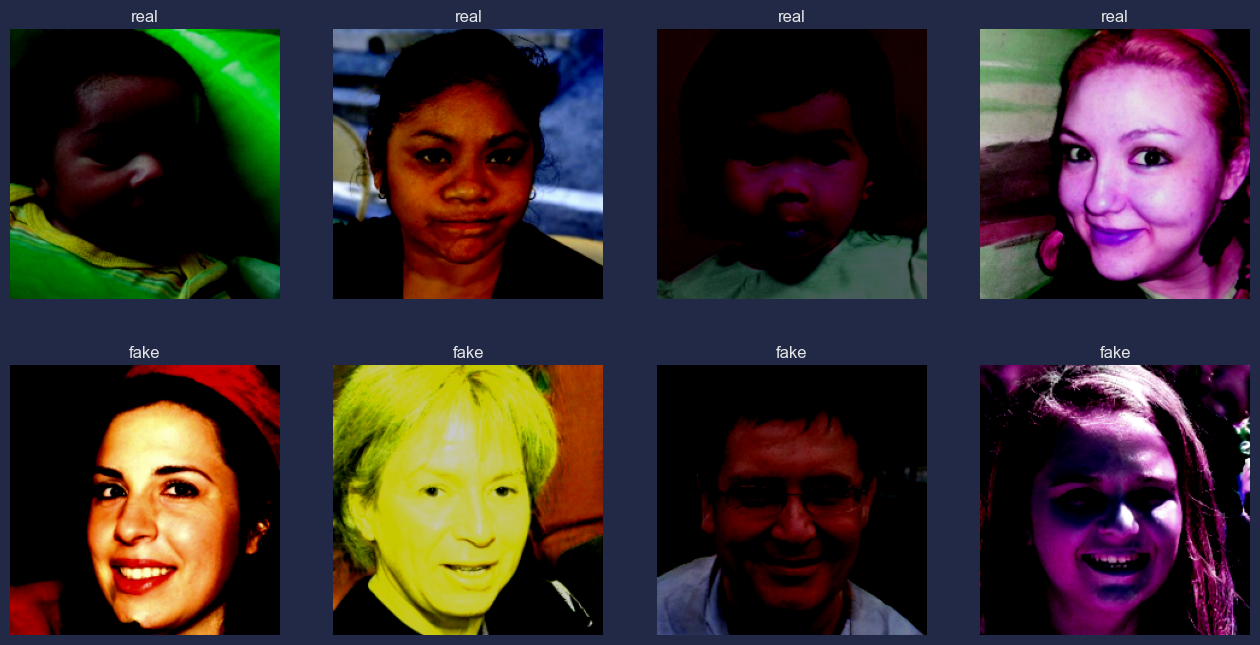

In [ ]:
# Visualize vit_train_dataset
visualize_images(vit_real_images, vit_fake_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..1.4722441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0904187..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6465361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.9754903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5455182..2.64].
Clip

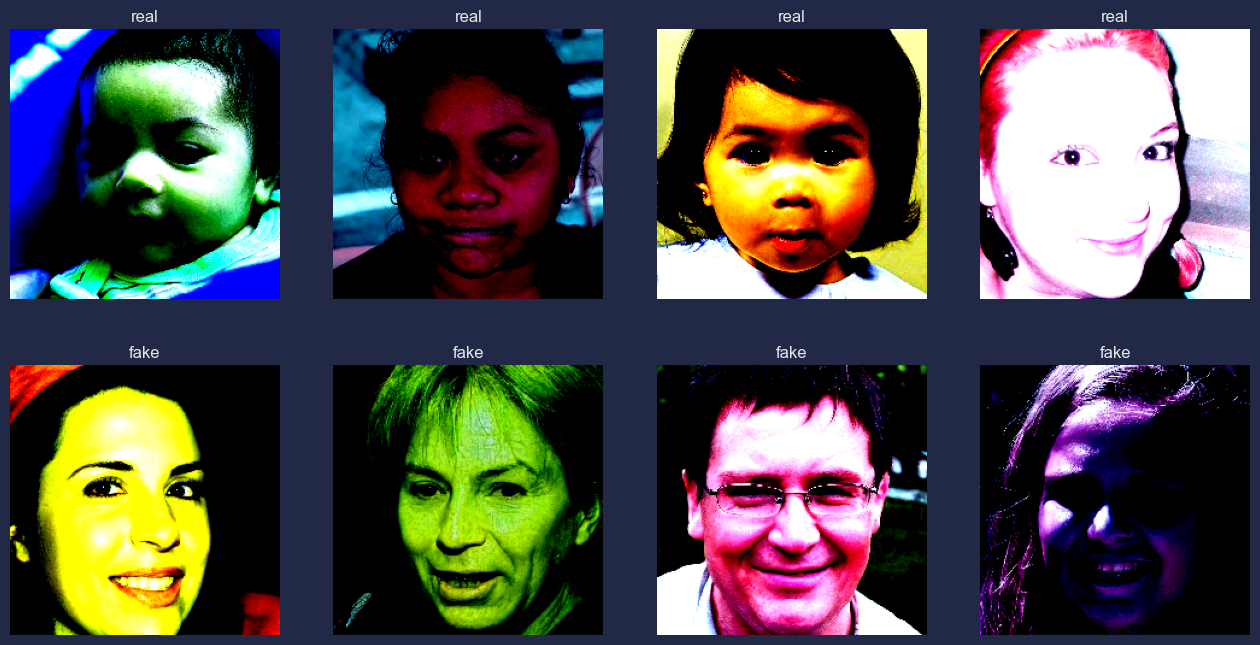

In [ ]:
# Visualize rn_train_dataset
visualize_images(rn_real_images, rn_fake_images)

# Model overview

In [ ]:
vit_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
rn_model

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
# Function to print the total and trainable parameters in a model
def print_trainable_parameters(model):
    """
    Prints the count of trainable and total parameters in the model, along with
    the percentage of parameters that are trainable.

    Parameters:
    - model: The neural network model containing layers with parameters.

    Prints:
    - Total number of trainable parameters.
    - Total number of all parameters.
    - Percentage of trainable parameters out of all parameters.
    """
    trainable_params = 0  # Initialize counter for trainable parameters
    all_param = 0  # Initialize counter for all parameters

    # Loop through each parameter in the model
    for _, param in model.named_parameters():
        all_param += param.numel()  # Count all parameters
        if param.requires_grad:  # Check if the parameter is trainable
            trainable_params += param.numel()  # Count trainable parameters

    # Print the summary of trainable vs. all parameters
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )


# Function to count and print trainable parameters for large layers
def count_trainable_parameters(model):
    """
    Prints the number of trainable parameters for each layer that has more than 10,000 trainable parameters.

    Parameters:
    - model: The neural network model containing layers with parameters.

    Prints:
    - Layer name and number of trainable parameters for each layer with > 10,000 trainable parameters.
    """
    # Loop through each parameter in the model
    for name, param in model.named_parameters():
        # Check if the parameter is trainable and has more than 10,000 elements
        if param.requires_grad and param.numel() > 10000:
            # Print the layer name and the number of trainable parameters
            print(f"Layer: {name} | Trainable parameters: {param.numel()}")


def freeze_params(model, freeze_top_percent):
    """
    Freezes a specified percentage of parameters starting from the first layers of the model.

    Parameters:
        model: The neural network model containing layers with parameters.
        freeze_top_percent: Percentage (0 to 1) of total parameters to be frozen.
    """
    # Calculate the total number of parameters in the model
    total_params = sum(param.numel() for param in model.parameters())
    target_freeze_params = int(total_params * freeze_top_percent)  # Number of parameters to freeze

    frozen_params = 0  # Counter for frozen parameters

    # Loop through each parameter in the model
    for param in model.parameters():
        if frozen_params >= target_freeze_params:
            break  # Stop if we’ve reached the target number of parameters to freeze
        param.requires_grad = False  # Freeze the current parameter
        frozen_params += param.numel()  # Update the count of frozen parameters

    print(f"Total parameters: {total_params}, Frozen parameters: {frozen_params}, Target: {target_freeze_params}")

In [ ]:
print_trainable_parameters(vit_model)

trainable params: 85800194 || all params: 85800194 || trainable%: 100.00


In [ ]:
print_trainable_parameters(rn_model)

trainable params: 23512130 || all params: 23512130 || trainable%: 100.00


In [ ]:
count_trainable_parameters(vit_model)

Layer: vit.embeddings.position_embeddings | Trainable parameters: 151296
Layer: vit.embeddings.patch_embeddings.projection.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.query.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.key.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.value.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.output.dense.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.intermediate.dense.weight | Trainable parameters: 2359296
Layer: vit.encoder.layer.0.output.dense.weight | Trainable parameters: 2359296
Layer: vit.encoder.layer.1.attention.attention.query.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.attention.key.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.attention.value.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.output.d

In [ ]:
count_trainable_parameters(rn_model)

Layer: resnet.encoder.stages.0.layers.0.shortcut.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.0.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.0.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.1.layer.0.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.1.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.1.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.2.layer.0.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.2.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.2.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.1.layers.0.shortcut.convolution.weight | Trainable parameters: 131072
Layer: resnet.encoder.stage

In [ ]:
freeze_params(vit_model, 1)
freeze_params(rn_model, 1)
freeze_params(base_vit_model, 0.95)
freeze_params(base_rn_model, 0.95)

Total parameters: 85800194, Frozen parameters: 85800194, Target: 85800194
Total parameters: 23512130, Frozen parameters: 23512130, Target: 23512130
Total parameters: 85800194, Frozen parameters: 83430912, Target: 81510184
Total parameters: 23512130, Frozen parameters: 22454336, Target: 22336523


In [ ]:
vit_config = LoraConfig(
    r=32,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["classifier"],
    target_modules=[
        "layer.0.attention.attention.query",
        "layer.0.attention.attention.key",
        "layer.0.attention.attention.value",
        "layer.1.attention.attention.query",
        "layer.1.attention.attention.key",
        "layer.1.attention.attention.value",
        "layer.2.attention.attention.query",
        "layer.2.attention.attention.key",
        "layer.2.attention.attention.value",
        "layer.3.attention.attention.query",
        "layer.3.attention.attention.key",
        "layer.3.attention.attention.value",
        "layer.4.attention.attention.query",
        "layer.4.attention.attention.key",
        "layer.4.attention.attention.value",
        "layer.5.attention.attention.query",
        "layer.5.attention.attention.key",
        "layer.5.attention.attention.value",
        "layer.6.attention.attention.query",
        "layer.6.attention.attention.key",
        "layer.6.attention.attention.value",
        "layer.7.attention.attention.query",
        "layer.7.attention.attention.key",
        "layer.7.attention.attention.value",
        "layer.8.attention.attention.query",
        "layer.8.attention.attention.key",
        "layer.8.attention.attention.value",
        "layer.9.attention.attention.query",
        "layer.9.attention.attention.key",
        "layer.9.attention.attention.value",
        "layer.10.attention.attention.query",
        "layer.10.attention.attention.key",
        "layer.10.attention.attention.value",
        "layer.11.attention.attention.query",
        "layer.11.attention.attention.key",
        "layer.11.attention.attention.value"
    ]
)

rn_config = LoraConfig(
    r=32,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["classifier"],
    target_modules=[
        "stages.2.layers.5.layer.0.convolution",
        "stages.2.layers.5.layer.1.convolution",
        "stages.2.layers.5.layer.2.convolution",
        "stages.3.layers.0.layer.0.convolution",
        "stages.3.layers.0.layer.1.convolution",
        "stages.3.layers.0.layer.2.convolution",
        "stages.3.layers.1.layer.0.convolution",
        "stages.3.layers.1.layer.1.convolution",
        "stages.3.layers.1.layer.2.convolution",
        "stages.3.layers.2.layer.0.convolution",
        "stages.3.layers.2.layer.1.convolution",
        "stages.3.layers.2.layer.2.convolution"
    ]
)

vit_lora_model = get_peft_model(vit_model, vit_config)
rn_lora_model = get_peft_model(rn_model, rn_config)

In [ ]:
print_trainable_parameters(vit_lora_model)

trainable params: 1771010 || all params: 87571204 || trainable%: 2.02


In [ ]:
print_trainable_parameters(rn_lora_model)

trainable params: 1118210 || all params: 24630340 || trainable%: 4.54


In [ ]:
print_trainable_parameters(base_vit_model)

trainable params: 2369282 || all params: 85800194 || trainable%: 2.76


In [ ]:
print_trainable_parameters(base_rn_model)

trainable params: 1057794 || all params: 23512130 || trainable%: 4.50


# Prepare Trainer

In [ ]:
def collate_fn(batch):
    """
    Custom collate function to prepare batched data for the model. This function
    stacks image pixel values and converts labels into a single tensor for each batch.

    Parameters:
        batch (list of dict): A list of dictionaries where each dictionary contains
                              'pixel_values' (image tensor) and 'labels' (int or tensor label).

    Returns:
        dict: A dictionary containing:
              - 'pixel_values' (tensor): A tensor of stacked images for the batch.
              - 'labels' (tensor): A tensor of corresponding labels for the batch.
    """

    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),  # Stack images into a single tensor
        'labels': torch.tensor([x['labels'] for x in batch])              # Convert labels to a single tensor
    }

In [ ]:
class CustomTrainer(Trainer):
    """
    Custom Trainer class for managing training and evaluation processes with additional metrics tracking.
    """

    def __init__(self, *args, **kwargs):
        """
        Initializes the CustomTrainer with additional attributes for tracking predictions, labels, and loss.
        """
        super().__init__(*args, **kwargs)  # Call the base class constructor
        self.epoch_predictions = []  # List to store predictions for each epoch
        self.epoch_labels = []  # List to store true labels for each epoch
        self.epoch_loss = []  # List to store loss values for each epoch

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Computes the loss based on the model outputs and the provided labels.

        Parameters:
            model: The model used for prediction.
            inputs: A dictionary of inputs to the model, which may include labels.
            return_outputs: A boolean flag to determine if the outputs should be returned alongside the loss.

        Returns:
            The computed loss, and optionally the model outputs.
        """
        labels = inputs.pop("labels", None)  # Extract labels if present
        outputs = model(**inputs)  # Forward pass

        # Compute and store predictions and labels if labels are provided
        if labels is not None:
            preds = outputs.logits.detach()
            class_preds = preds.argmax(axis=1)

            # Store epoch predictions and labels for metrics
            self.epoch_predictions.append(class_preds.cpu().numpy())
            self.epoch_labels.append(labels.cpu().numpy())

            # Use label smoothing if applicable
            loss = self.label_smoother(outputs, labels)
        else:
            # If labels are not present, get loss from outputs directly
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        # Store loss for epoch-level metrics
        self.epoch_loss.append(loss.item())

        # Return loss and optionally outputs
        return (loss, outputs) if return_outputs else loss


In [ ]:
class CustomCallback(TrainerCallback):
    """
    Custom callback for logging metrics at the end of each epoch,
    including a classification report and memory usage.
    """

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        """
        This function is triggered at the end of each epoch.
        It generates a classification report, a confusion matrix, logs mean loss, and memory usage,
        then clears epoch-level data for the next epoch.

        Parameters:
            args (TrainingArguments): Training configuration parameters.
            state (TrainerState): Information about the current training state.
            control (TrainerControl): Directions for the next steps in the training loop.
        """

        # Apply threshold to predictions and concatenate for epoch-level metrics
        epoch_predictions = np.concatenate(self._trainer.epoch_predictions)
        epoch_labels = np.concatenate(self._trainer.epoch_labels)

        # Compute mean loss for the epoch
        mean_loss = np.mean(self._trainer.epoch_loss)

        # Generate a classification report for detailed metrics
        report = classification_report(epoch_labels, epoch_predictions)

        # Print mean loss and classification report
        print(f"Mean Loss: {mean_loss:.4f}")
        print("Classification Report:\n", report)

        # Calculate and print confusion matrix
        cm = confusion_matrix(epoch_labels, epoch_predictions)
        print("Confusion Matrix:\n", cm)

        # Clear stored predictions, labels, and loss for the next epoch
        self._trainer.epoch_predictions = []
        self._trainer.epoch_labels = []
        self._trainer.epoch_loss = []

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',           # output directory
    auto_find_batch_size=True,   # batch size for training
    num_train_epochs=1,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='logs',             # directory for storing logs
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=1,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

# Training

## First epoch

### First subdataset

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train()

  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 0.6813, 'grad_norm': 0.838194727897644, 'learning_rate': 4e-05, 'epoch': 0.2}
{'loss': 0.6676, 'grad_norm': 0.837626039981842, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 0.6555, 'grad_norm': 1.2501434087753296, 'learning_rate': 2e-05, 'epoch': 0.6}
{'loss': 0.6521, 'grad_norm': 1.5483092069625854, 'learning_rate': 1e-05, 'epoch': 0.8}
{'loss': 0.6453, 'grad_norm': 1.035946011543274, 'learning_rate': 2e-08, 'epoch': 1.0}
Mean Loss: 0.6603
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.57      0.63     10000
           1       0.64      0.75      0.69     10000

    accuracy                           0.66     20000
   macro avg       0.67      0.66      0.66     20000
weighted avg       0.67      0.66      0.66     20000

Confusion Matrix:
 [[5723 4277]
 [2493 7507]]
{'train_runtime': 798.6925, 'train_samples_per_second': 25.041, 'train_steps_per_second': 3.13, 'train_loss': 0.6603420288085937, 'epoch': 1.0}


TrainOutput(global_step=2500, training_loss=0.6603420288085937, metrics={'train_runtime': 798.6925, 'train_samples_per_second': 25.041, 'train_steps_per_second': 3.13, 'total_flos': 4.247080685568e+17, 'train_loss': 0.6603420288085937, 'epoch': 1.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train()

  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 0.6484, 'grad_norm': 4.3849992752075195, 'learning_rate': 4.002e-05, 'epoch': 0.2}
{'loss': 0.5861, 'grad_norm': 2.8631725311279297, 'learning_rate': 3.0020000000000004e-05, 'epoch': 0.4}
{'loss': 0.5542, 'grad_norm': 4.47163200378418, 'learning_rate': 2.002e-05, 'epoch': 0.6}
{'loss': 0.5542, 'grad_norm': 7.355507850646973, 'learning_rate': 1.002e-05, 'epoch': 0.8}
{'loss': 0.534, 'grad_norm': 5.607637405395508, 'learning_rate': 2e-08, 'epoch': 1.0}
Mean Loss: 0.5754
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73     10000
           1       0.73      0.71      0.72     10000

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000

Confusion Matrix:
 [[7363 2637]
 [2871 7129]]
{'train_runtime': 2421.6657, 'train_samples_per_second': 8.259, 'train_steps_per_second': 1.032, 'train_loss': 0.57538529

TrainOutput(global_step=2500, training_loss=0.5753852905273438, metrics={'train_runtime': 2421.6657, 'train_samples_per_second': 8.259, 'train_steps_per_second': 1.032, 'total_flos': 1.54983979229184e+18, 'train_loss': 0.5753852905273438, 'epoch': 1.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train()

  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 0.6861, 'grad_norm': 0.8270769715309143, 'learning_rate': 4e-05, 'epoch': 0.2}
{'loss': 0.6656, 'grad_norm': 0.8530653119087219, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 0.6363, 'grad_norm': 1.0843168497085571, 'learning_rate': 2e-05, 'epoch': 0.6}
{'loss': 0.6138, 'grad_norm': 1.3749057054519653, 'learning_rate': 1e-05, 'epoch': 0.8}
{'loss': 0.5944, 'grad_norm': 0.9316421151161194, 'learning_rate': 2e-08, 'epoch': 1.0}
Mean Loss: 0.6392
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.60      0.64     10000
           1       0.64      0.73      0.68     10000

    accuracy                           0.66     20000
   macro avg       0.67      0.66      0.66     20000
weighted avg       0.67      0.66      0.66     20000

Confusion Matrix:
 [[5972 4028]
 [2704 7296]]
{'train_runtime': 985.3367, 'train_samples_per_second': 20.298, 'train_steps_per_second': 2.537, 'train_loss': 0.6392403442382812, 'epoch': 1.0}


TrainOutput(global_step=2500, training_loss=0.6392403442382812, metrics={'train_runtime': 985.3367, 'train_samples_per_second': 20.298, 'train_steps_per_second': 2.537, 'total_flos': 4.449066983424e+17, 'train_loss': 0.6392403442382812, 'epoch': 1.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train()

  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 0.6288, 'grad_norm': 4.009792327880859, 'learning_rate': 4.002e-05, 'epoch': 0.2}
{'loss': 0.5257, 'grad_norm': 2.446727752685547, 'learning_rate': 3.0020000000000004e-05, 'epoch': 0.4}
{'loss': 0.4464, 'grad_norm': 4.545102596282959, 'learning_rate': 2.002e-05, 'epoch': 0.6}
{'loss': 0.4197, 'grad_norm': 3.9164090156555176, 'learning_rate': 1.004e-05, 'epoch': 0.8}
{'loss': 0.3986, 'grad_norm': 3.139768362045288, 'learning_rate': 4e-08, 'epoch': 1.0}
Mean Loss: 0.4838
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     10000
           1       0.81      0.79      0.80     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000

Confusion Matrix:
 [[8108 1892]
 [2108 7892]]
{'train_runtime': 9408.9383, 'train_samples_per_second': 2.126, 'train_steps_per_second': 0.266, 'train_loss': 0.4838326

TrainOutput(global_step=2500, training_loss=0.4838326232910156, metrics={'train_runtime': 9408.9383, 'train_samples_per_second': 2.126, 'train_steps_per_second': 0.266, 'total_flos': 1.58183018348544e+18, 'train_loss': 0.4838326232910156, 'epoch': 1.0})

### Second subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=2,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-2500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6419, 'grad_norm': 0.9176211357116699, 'learning_rate': 2.001e-05, 'epoch': 1.2}
{'loss': 0.6386, 'grad_norm': 0.6909989714622498, 'learning_rate': 1.5010000000000002e-05, 'epoch': 1.4}
{'loss': 0.6377, 'grad_norm': 0.9034386277198792, 'learning_rate': 1.001e-05, 'epoch': 1.6}
{'loss': 0.6329, 'grad_norm': 1.15224289894104, 'learning_rate': 5.01e-06, 'epoch': 1.8}
{'loss': 0.6323, 'grad_norm': 1.9047083854675293, 'learning_rate': 2e-08, 'epoch': 2.0}
Mean Loss: 0.6367
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.65      0.68     10000
           1       0.67      0.73      0.70     10000

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000

Confusion Matrix:
 [[6457 3543]
 [2651 7349]]
{'train_runtime': 747.9802, 'train_samples_per_second': 53.477, 'train_steps_per_second': 6.685, 'train_loss': 0.318334

TrainOutput(global_step=5000, training_loss=0.3183349304199219, metrics={'train_runtime': 747.9802, 'train_samples_per_second': 53.477, 'train_steps_per_second': 6.685, 'total_flos': 8.494161371136e+17, 'train_loss': 0.3183349304199219, 'epoch': 2.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-2500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5275, 'grad_norm': 3.3852221965789795, 'learning_rate': 2.001e-05, 'epoch': 1.2}
{'loss': 0.514, 'grad_norm': 3.6000072956085205, 'learning_rate': 1.502e-05, 'epoch': 1.4}
{'loss': 0.525, 'grad_norm': 4.277674674987793, 'learning_rate': 1.002e-05, 'epoch': 1.6}
{'loss': 0.5288, 'grad_norm': 6.297835826873779, 'learning_rate': 5.02e-06, 'epoch': 1.8}
{'loss': 0.5153, 'grad_norm': 7.16810941696167, 'learning_rate': 2e-08, 'epoch': 2.0}
Mean Loss: 0.5221
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78     10000
           1       0.78      0.77      0.77     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7805 2195]
 [2293 7707]]
{'train_runtime': 4995.0215, 'train_samples_per_second': 8.008, 'train_steps_per_second': 1.001, 'train_loss': 0.261069384765625, 'epoch

TrainOutput(global_step=5000, training_loss=0.261069384765625, metrics={'train_runtime': 4995.0215, 'train_samples_per_second': 8.008, 'train_steps_per_second': 1.001, 'total_flos': 3.09967958458368e+18, 'train_loss': 0.261069384765625, 'epoch': 2.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-2500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5853, 'grad_norm': 1.282539963722229, 'learning_rate': 2.001e-05, 'epoch': 1.2}
{'loss': 0.5768, 'grad_norm': 0.6895952820777893, 'learning_rate': 1.5010000000000002e-05, 'epoch': 1.4}
{'loss': 0.577, 'grad_norm': 0.7401747703552246, 'learning_rate': 1.001e-05, 'epoch': 1.6}
{'loss': 0.5737, 'grad_norm': 0.9923574328422546, 'learning_rate': 5.01e-06, 'epoch': 1.8}
{'loss': 0.568, 'grad_norm': 2.3431406021118164, 'learning_rate': 2e-08, 'epoch': 2.0}
Mean Loss: 0.5762
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72     10000
           1       0.72      0.75      0.73     10000

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000

Confusion Matrix:
 [[7017 2983]
 [2495 7505]]
{'train_runtime': 858.1201, 'train_samples_per_second': 46.614, 'train_steps_per_second': 5.827, 'train_loss': 0.2880818

TrainOutput(global_step=5000, training_loss=0.2880818298339844, metrics={'train_runtime': 858.1201, 'train_samples_per_second': 46.614, 'train_steps_per_second': 5.827, 'total_flos': 8.898133966848e+17, 'train_loss': 0.2880818298339844, 'epoch': 2.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-2500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3852, 'grad_norm': 1.0216249227523804, 'learning_rate': 2.0030000000000003e-05, 'epoch': 1.2}
{'loss': 0.3695, 'grad_norm': 2.5587308406829834, 'learning_rate': 1.503e-05, 'epoch': 1.4}
{'loss': 0.3724, 'grad_norm': 1.668418049812317, 'learning_rate': 1.004e-05, 'epoch': 1.6}
{'loss': 0.3649, 'grad_norm': 8.043546676635742, 'learning_rate': 5.04e-06, 'epoch': 1.8}
{'loss': 0.3575, 'grad_norm': 3.686152935028076, 'learning_rate': 4e-08, 'epoch': 2.0}
Mean Loss: 0.3699
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     10000
           1       0.90      0.89      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Confusion Matrix:
 [[8976 1024]
 [1051 8949]]
{'train_runtime': 9285.9035, 'train_samples_per_second': 4.308, 'train_steps_per_second': 0.538, 'train_loss': 0.1849521

TrainOutput(global_step=5000, training_loss=0.18495216369628906, metrics={'train_runtime': 9285.9035, 'train_samples_per_second': 4.308, 'train_steps_per_second': 0.538, 'total_flos': 3.16366036697088e+18, 'train_loss': 0.18495216369628906, 'epoch': 2.0})

### Third subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=3,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-5000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/7500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6322, 'grad_norm': 0.7287797331809998, 'learning_rate': 1.3346666666666669e-05, 'epoch': 2.2}
{'loss': 0.6255, 'grad_norm': 1.5115580558776855, 'learning_rate': 1.0013333333333335e-05, 'epoch': 2.4}
{'loss': 0.6229, 'grad_norm': 0.8810093998908997, 'learning_rate': 6.68e-06, 'epoch': 2.6}
{'loss': 0.6239, 'grad_norm': 2.7507190704345703, 'learning_rate': 3.3466666666666667e-06, 'epoch': 2.8}
{'loss': 0.6259, 'grad_norm': 0.9361724853515625, 'learning_rate': 2e-08, 'epoch': 3.0}
Mean Loss: 0.6261
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.67      0.69     10000
           1       0.69      0.72      0.70     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000

Confusion Matrix:
 [[6683 3317]
 [2765 7235]]
{'train_runtime': 1156.3346, 'train_samples_per_second': 51.888, 'train_steps_per_second': 

TrainOutput(global_step=7500, training_loss=0.20869431559244792, metrics={'train_runtime': 1156.3346, 'train_samples_per_second': 51.888, 'train_steps_per_second': 6.486, 'total_flos': 1.2741242056704e+18, 'train_loss': 0.20869431559244792, 'epoch': 3.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-5000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/7500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5137, 'grad_norm': 5.156214237213135, 'learning_rate': 1.3353333333333335e-05, 'epoch': 2.2}
{'loss': 0.5088, 'grad_norm': 3.74015474319458, 'learning_rate': 1.002e-05, 'epoch': 2.4}
{'loss': 0.5082, 'grad_norm': 2.3078911304473877, 'learning_rate': 6.686666666666667e-06, 'epoch': 2.6}
{'loss': 0.4997, 'grad_norm': 7.110501289367676, 'learning_rate': 3.353333333333333e-06, 'epoch': 2.8}
{'loss': 0.5029, 'grad_norm': 4.090071201324463, 'learning_rate': 2.666666666666667e-08, 'epoch': 3.0}
Mean Loss: 0.5067
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     10000
           1       0.80      0.78      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Confusion Matrix:
 [[8025 1975]
 [2215 7785]]
{'train_runtime': 4887.1215, 'train_samples_per_second': 12.277, 'train_steps_per

TrainOutput(global_step=7500, training_loss=0.16889476521809896, metrics={'train_runtime': 4887.1215, 'train_samples_per_second': 12.277, 'train_steps_per_second': 1.535, 'total_flos': 4.64951937687552e+18, 'train_loss': 0.16889476521809896, 'epoch': 3.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-5000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/7500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5577, 'grad_norm': 0.8232594728469849, 'learning_rate': 1.3346666666666669e-05, 'epoch': 2.2}
{'loss': 0.5578, 'grad_norm': 1.188016414642334, 'learning_rate': 1.0013333333333335e-05, 'epoch': 2.4}
{'loss': 0.5578, 'grad_norm': 1.0319117307662964, 'learning_rate': 6.68e-06, 'epoch': 2.6}
{'loss': 0.5562, 'grad_norm': 2.6975886821746826, 'learning_rate': 3.3466666666666667e-06, 'epoch': 2.8}
{'loss': 0.5587, 'grad_norm': 0.9950183033943176, 'learning_rate': 2e-08, 'epoch': 3.0}
Mean Loss: 0.5576
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74     10000
           1       0.73      0.76      0.75     10000

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

Confusion Matrix:
 [[7265 2735]
 [2428 7572]]
{'train_runtime': 1510.4739, 'train_samples_per_second': 39.723, 'train_steps_per_second': 4

TrainOutput(global_step=7500, training_loss=0.18588055826822916, metrics={'train_runtime': 1510.4739, 'train_samples_per_second': 39.723, 'train_steps_per_second': 4.965, 'total_flos': 1.3347200950272e+18, 'train_loss': 0.18588055826822916, 'epoch': 3.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-5000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/7500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3503, 'grad_norm': 5.180073261260986, 'learning_rate': 1.3366666666666667e-05, 'epoch': 2.2}
{'loss': 0.3469, 'grad_norm': 2.310532569885254, 'learning_rate': 1.0033333333333333e-05, 'epoch': 2.4}
{'loss': 0.3462, 'grad_norm': 4.4865403175354, 'learning_rate': 6.706666666666666e-06, 'epoch': 2.6}
{'loss': 0.3425, 'grad_norm': 3.7473371028900146, 'learning_rate': 3.38e-06, 'epoch': 2.8}
{'loss': 0.3402, 'grad_norm': 2.415271520614624, 'learning_rate': 4.666666666666667e-08, 'epoch': 3.0}
Mean Loss: 0.3452
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92     10000
           1       0.92      0.91      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
 [[9190  810]
 [ 876 9124]]
{'train_runtime': 4511.0589, 'train_samples_per_second': 13.301, 'train_steps_per_

TrainOutput(global_step=7500, training_loss=0.11507601114908854, metrics={'train_runtime': 4511.0589, 'train_samples_per_second': 13.301, 'train_steps_per_second': 1.663, 'total_flos': 4.74549055045632e+18, 'train_loss': 0.11507601114908854, 'epoch': 3.0})

### Fourth subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=4,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-7500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6223, 'grad_norm': 0.8720371127128601, 'learning_rate': 1.0015000000000002e-05, 'epoch': 3.2}
{'loss': 0.6176, 'grad_norm': 1.3109420537948608, 'learning_rate': 7.515e-06, 'epoch': 3.4}
{'loss': 0.6223, 'grad_norm': 1.0179773569107056, 'learning_rate': 5.015e-06, 'epoch': 3.6}
{'loss': 0.6196, 'grad_norm': 0.979070246219635, 'learning_rate': 2.515e-06, 'epoch': 3.8}
{'loss': 0.6169, 'grad_norm': 0.8058207035064697, 'learning_rate': 2e-08, 'epoch': 4.0}
Mean Loss: 0.6197
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.67      0.69     10000
           1       0.69      0.74      0.71     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000

Confusion Matrix:
 [[6667 3333]
 [2646 7354]]
{'train_runtime': 1157.0625, 'train_samples_per_second': 69.141, 'train_steps_per_second': 8.643, 'train_loss': 0.154

TrainOutput(global_step=10000, training_loss=0.15492980346679688, metrics={'train_runtime': 1157.0625, 'train_samples_per_second': 69.141, 'train_steps_per_second': 8.643, 'total_flos': 1.6988322742272e+18, 'train_loss': 0.15492980346679688, 'epoch': 4.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-7500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5147, 'grad_norm': 4.236164093017578, 'learning_rate': 1.0025000000000001e-05, 'epoch': 3.2}
{'loss': 0.4884, 'grad_norm': 2.1376590728759766, 'learning_rate': 7.525e-06, 'epoch': 3.4}
{'loss': 0.4942, 'grad_norm': 4.0559492111206055, 'learning_rate': 5.025e-06, 'epoch': 3.6}
{'loss': 0.5024, 'grad_norm': 3.2693052291870117, 'learning_rate': 2.5250000000000004e-06, 'epoch': 3.8}
{'loss': 0.4945, 'grad_norm': 5.804433345794678, 'learning_rate': 2.5000000000000002e-08, 'epoch': 4.0}
Mean Loss: 0.4988
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     10000
           1       0.80      0.79      0.80     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000

Confusion Matrix:
 [[8068 1932]
 [2114 7886]]
{'train_runtime': 4915.616, 'train_samples_per_second': 16.275, 'train_steps_per_second'

TrainOutput(global_step=10000, training_loss=0.12471116638183594, metrics={'train_runtime': 4915.616, 'train_samples_per_second': 16.275, 'train_steps_per_second': 2.034, 'total_flos': 6.19935916916736e+18, 'train_loss': 0.12471116638183594, 'epoch': 4.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-7500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5481, 'grad_norm': 0.8475444912910461, 'learning_rate': 1.002e-05, 'epoch': 3.2}
{'loss': 0.5414, 'grad_norm': 1.215224266052246, 'learning_rate': 7.520000000000001e-06, 'epoch': 3.4}
{'loss': 0.5528, 'grad_norm': 0.7698142528533936, 'learning_rate': 5.02e-06, 'epoch': 3.6}
{'loss': 0.5508, 'grad_norm': 0.9855321049690247, 'learning_rate': 2.52e-06, 'epoch': 3.8}
{'loss': 0.5444, 'grad_norm': 0.8750051259994507, 'learning_rate': 2e-08, 'epoch': 4.0}
Mean Loss: 0.5475
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74     10000
           1       0.74      0.76      0.75     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7338 2662]
 [2385 7615]]
{'train_runtime': 1304.4287, 'train_samples_per_second': 61.33, 'train_steps_per_second': 7.666, 'train_loss': 0.1368710

TrainOutput(global_step=10000, training_loss=0.1368710723876953, metrics={'train_runtime': 1304.4287, 'train_samples_per_second': 61.33, 'train_steps_per_second': 7.666, 'total_flos': 1.7796267933696e+18, 'train_loss': 0.1368710723876953, 'epoch': 4.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-7500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3447, 'grad_norm': 5.207077980041504, 'learning_rate': 1.004e-05, 'epoch': 3.2}
{'loss': 0.3276, 'grad_norm': 2.4768126010894775, 'learning_rate': 7.54e-06, 'epoch': 3.4}
{'loss': 0.324, 'grad_norm': 2.7337229251861572, 'learning_rate': 5.04e-06, 'epoch': 3.6}
{'loss': 0.3358, 'grad_norm': 0.5901905298233032, 'learning_rate': 2.545e-06, 'epoch': 3.8}
{'loss': 0.3228, 'grad_norm': 3.5266082286834717, 'learning_rate': 4.5e-08, 'epoch': 4.0}
Mean Loss: 0.3310
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     10000
           1       0.93      0.92      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Confusion Matrix:
 [[9314  686]
 [ 787 9213]]
{'train_runtime': 9372.3096, 'train_samples_per_second': 8.536, 'train_steps_per_second': 1.067, 'train_loss': 0.08275206451416016,

TrainOutput(global_step=10000, training_loss=0.08275206451416016, metrics={'train_runtime': 9372.3096, 'train_samples_per_second': 8.536, 'train_steps_per_second': 1.067, 'total_flos': 6.32732073394176e+18, 'train_loss': 0.08275206451416016, 'epoch': 4.0})

### Fifth subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=5,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-10000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/12500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6273, 'grad_norm': 1.0169596672058105, 'learning_rate': 8.015999999999999e-06, 'epoch': 4.2}
{'loss': 0.6133, 'grad_norm': 1.0025322437286377, 'learning_rate': 6.0160000000000005e-06, 'epoch': 4.4}
{'loss': 0.6156, 'grad_norm': 0.9165505170822144, 'learning_rate': 4.016e-06, 'epoch': 4.6}
{'loss': 0.6179, 'grad_norm': 1.4019131660461426, 'learning_rate': 2.0160000000000003e-06, 'epoch': 4.8}
{'loss': 0.6212, 'grad_norm': 1.0146080255508423, 'learning_rate': 2e-08, 'epoch': 5.0}
Mean Loss: 0.6191
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.66      0.68     10000
           1       0.68      0.72      0.70     10000

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000

Confusion Matrix:
 [[6579 3421]
 [2750 7250]]
{'train_runtime': 730.7814, 'train_samples_per_second': 136.84, 'train_steps_per_second': 1

TrainOutput(global_step=12500, training_loss=0.1238118798828125, metrics={'train_runtime': 730.7814, 'train_samples_per_second': 136.84, 'train_steps_per_second': 17.105, 'total_flos': 2.123540342784e+18, 'train_loss': 0.1238118798828125, 'epoch': 5.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-10000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/12500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5007, 'grad_norm': 2.974761962890625, 'learning_rate': 8.02e-06, 'epoch': 4.2}
{'loss': 0.4894, 'grad_norm': 3.2863588333129883, 'learning_rate': 6.02e-06, 'epoch': 4.4}
{'loss': 0.4943, 'grad_norm': 2.800157308578491, 'learning_rate': 4.024e-06, 'epoch': 4.6}
{'loss': 0.4922, 'grad_norm': 5.335672855377197, 'learning_rate': 2.024e-06, 'epoch': 4.8}
{'loss': 0.5044, 'grad_norm': 3.9630231857299805, 'learning_rate': 2.4000000000000003e-08, 'epoch': 5.0}
Mean Loss: 0.4962
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.80     10000
           1       0.80      0.79      0.79     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000

Confusion Matrix:
 [[8040 1960]
 [2136 7864]]
{'train_runtime': 4993.3816, 'train_samples_per_second': 20.027, 'train_steps_per_second': 2.503, 'train_loss': 0.099

TrainOutput(global_step=12500, training_loss=0.099238134765625, metrics={'train_runtime': 4993.3816, 'train_samples_per_second': 20.027, 'train_steps_per_second': 2.503, 'total_flos': 7.7491989614592e+18, 'train_loss': 0.099238134765625, 'epoch': 5.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-10000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/12500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5583, 'grad_norm': 0.9806052446365356, 'learning_rate': 8.015999999999999e-06, 'epoch': 4.2}
{'loss': 0.536, 'grad_norm': 0.808613121509552, 'learning_rate': 6.0160000000000005e-06, 'epoch': 4.4}
{'loss': 0.5457, 'grad_norm': 0.7798320651054382, 'learning_rate': 4.016e-06, 'epoch': 4.6}
{'loss': 0.5532, 'grad_norm': 1.4251999855041504, 'learning_rate': 2.0160000000000003e-06, 'epoch': 4.8}
{'loss': 0.5495, 'grad_norm': 0.8953227996826172, 'learning_rate': 2e-08, 'epoch': 5.0}
Mean Loss: 0.5485
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     10000
           1       0.75      0.76      0.75     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
 [[7415 2585]
 [2404 7596]]
{'train_runtime': 978.848, 'train_samples_per_second': 102.161, 'train_steps_per_second': 12.

TrainOutput(global_step=12500, training_loss=0.10970787109375, metrics={'train_runtime': 978.848, 'train_samples_per_second': 102.161, 'train_steps_per_second': 12.77, 'total_flos': 2.224533491712e+18, 'train_loss': 0.10970787109375, 'epoch': 5.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-10000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/12500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3263, 'grad_norm': 0.9907905459403992, 'learning_rate': 8.040000000000001e-06, 'epoch': 4.2}
{'loss': 0.3192, 'grad_norm': 4.053230285644531, 'learning_rate': 6.040000000000001e-06, 'epoch': 4.4}
{'loss': 0.3269, 'grad_norm': 0.6676504015922546, 'learning_rate': 4.04e-06, 'epoch': 4.6}
{'loss': 0.3154, 'grad_norm': 3.0463011264801025, 'learning_rate': 2.0400000000000004e-06, 'epoch': 4.8}
{'loss': 0.3193, 'grad_norm': 1.3356648683547974, 'learning_rate': 4e-08, 'epoch': 5.0}
Mean Loss: 0.3214
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     10000
           1       0.94      0.93      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Confusion Matrix:
 [[9401  599]
 [ 724 9276]]
{'train_runtime': 9417.1388, 'train_samples_per_second': 10.619, 'train_steps_per_second': 1.3

TrainOutput(global_step=12500, training_loss=0.06428506713867188, metrics={'train_runtime': 9417.1388, 'train_samples_per_second': 10.619, 'train_steps_per_second': 1.327, 'total_flos': 7.9091509174272e+18, 'train_loss': 0.06428506713867188, 'epoch': 5.0})

## Second epoch

### First subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=6,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-12500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/15000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6165, 'grad_norm': 0.9612447619438171, 'learning_rate': 6.6833333333333334e-06, 'epoch': 5.2}
{'loss': 0.6161, 'grad_norm': 0.7830770611763, 'learning_rate': 5.016666666666666e-06, 'epoch': 5.4}
{'loss': 0.614, 'grad_norm': 2.06744647026062, 'learning_rate': 3.3500000000000005e-06, 'epoch': 5.6}
{'loss': 0.6181, 'grad_norm': 0.6984010338783264, 'learning_rate': 1.6833333333333332e-06, 'epoch': 5.8}
{'loss': 0.6097, 'grad_norm': 0.925857663154602, 'learning_rate': 2e-08, 'epoch': 6.0}
Mean Loss: 0.6149
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.67      0.69     10000
           1       0.69      0.72      0.70     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000

Confusion Matrix:
 [[6677 3323]
 [2765 7235]]
{'train_runtime': 1078.3939, 'train_samples_per_second': 111.277, 'train_steps_per_se

TrainOutput(global_step=15000, training_loss=0.10248221435546875, metrics={'train_runtime': 1078.3939, 'train_samples_per_second': 111.277, 'train_steps_per_second': 13.91, 'total_flos': 2.5482484113408e+18, 'train_loss': 0.10248221435546875, 'epoch': 6.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-12500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/15000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4828, 'grad_norm': 3.969029188156128, 'learning_rate': 6.69e-06, 'epoch': 5.2}
{'loss': 0.485, 'grad_norm': 5.885052680969238, 'learning_rate': 5.023333333333333e-06, 'epoch': 5.4}
{'loss': 0.4932, 'grad_norm': 4.739204406738281, 'learning_rate': 3.356666666666667e-06, 'epoch': 5.6}
{'loss': 0.4862, 'grad_norm': 2.6472790241241455, 'learning_rate': 1.69e-06, 'epoch': 5.8}
{'loss': 0.485, 'grad_norm': 3.672009229660034, 'learning_rate': 2.3333333333333334e-08, 'epoch': 6.0}
Mean Loss: 0.4864
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81     10000
           1       0.81      0.80      0.80     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

Confusion Matrix:
 [[8171 1829]
 [2050 7950]]
{'train_runtime': 2605.3453, 'train_samples_per_second': 46.059, 'train_steps_per_second': 5.757

TrainOutput(global_step=15000, training_loss=0.08107001749674479, metrics={'train_runtime': 2605.3453, 'train_samples_per_second': 46.059, 'train_steps_per_second': 5.757, 'total_flos': 9.29903875375104e+18, 'train_loss': 0.08107001749674479, 'epoch': 6.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-12500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/15000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5406, 'grad_norm': 1.3038920164108276, 'learning_rate': 6.6833333333333334e-06, 'epoch': 5.2}
{'loss': 0.5351, 'grad_norm': 1.439281702041626, 'learning_rate': 5.016666666666666e-06, 'epoch': 5.4}
{'loss': 0.5304, 'grad_norm': 2.0891382694244385, 'learning_rate': 3.3500000000000005e-06, 'epoch': 5.6}
{'loss': 0.5403, 'grad_norm': 0.44290876388549805, 'learning_rate': 1.6833333333333332e-06, 'epoch': 5.8}
{'loss': 0.5239, 'grad_norm': 0.9590340256690979, 'learning_rate': 2e-08, 'epoch': 6.0}
Mean Loss: 0.5340
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76     10000
           1       0.75      0.77      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion Matrix:
 [[7492 2508]
 [2279 7721]]
{'train_runtime': 1295.6423, 'train_samples_per_second': 92.618, 'train_steps_

TrainOutput(global_step=15000, training_loss=0.08900347493489583, metrics={'train_runtime': 1295.6423, 'train_samples_per_second': 92.618, 'train_steps_per_second': 11.577, 'total_flos': 2.6694401900544e+18, 'train_loss': 0.08900347493489583, 'epoch': 6.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-12500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/15000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.318, 'grad_norm': 2.3473973274230957, 'learning_rate': 6.703333333333334e-06, 'epoch': 5.2}
{'loss': 0.3217, 'grad_norm': 4.176771640777588, 'learning_rate': 5.036666666666667e-06, 'epoch': 5.4}
{'loss': 0.32, 'grad_norm': 3.165485382080078, 'learning_rate': 3.3733333333333334e-06, 'epoch': 5.6}
{'loss': 0.3055, 'grad_norm': 2.466672658920288, 'learning_rate': 1.706666666666667e-06, 'epoch': 5.8}
{'loss': 0.3104, 'grad_norm': 2.5215954780578613, 'learning_rate': 4e-08, 'epoch': 6.0}
Mean Loss: 0.3151
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     10000
           1       0.94      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix:
 [[9414  586]
 [ 668 9332]]
{'train_runtime': 9403.2221, 'train_samples_per_second': 12.762, 'train_steps_per_seco

TrainOutput(global_step=15000, training_loss=0.05251827697753906, metrics={'train_runtime': 9403.2221, 'train_samples_per_second': 12.762, 'train_steps_per_second': 1.595, 'total_flos': 9.49098110091264e+18, 'train_loss': 0.05251827697753906, 'epoch': 6.0})

### Second subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=7,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-15000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/17500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6102, 'grad_norm': 0.9062875509262085, 'learning_rate': 5.731428571428572e-06, 'epoch': 6.2}
{'loss': 0.6083, 'grad_norm': 0.891099214553833, 'learning_rate': 4.302857142857143e-06, 'epoch': 6.4}
{'loss': 0.6069, 'grad_norm': 0.985965371131897, 'learning_rate': 2.8742857142857146e-06, 'epoch': 6.6}
{'loss': 0.6095, 'grad_norm': 0.8575844764709473, 'learning_rate': 1.4457142857142858e-06, 'epoch': 6.8}
{'loss': 0.6128, 'grad_norm': 1.4908066987991333, 'learning_rate': 2e-08, 'epoch': 7.0}
Mean Loss: 0.6095
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.67      0.70     10000
           1       0.69      0.74      0.71     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6737 3263]
 [2622 7378]]
{'train_runtime': 656.4591, 'train_samples_per_second': 213.265, 'train_steps_per

TrainOutput(global_step=17500, training_loss=0.08707440883091518, metrics={'train_runtime': 656.4591, 'train_samples_per_second': 213.265, 'train_steps_per_second': 26.658, 'total_flos': 2.9729564798976e+18, 'train_loss': 0.08707440883091518, 'epoch': 7.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-15000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/17500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4871, 'grad_norm': 4.089580535888672, 'learning_rate': 5.737142857142858e-06, 'epoch': 6.2}
{'loss': 0.472, 'grad_norm': 5.253572940826416, 'learning_rate': 4.308571428571429e-06, 'epoch': 6.4}
{'loss': 0.4925, 'grad_norm': 4.070521354675293, 'learning_rate': 2.88e-06, 'epoch': 6.6}
{'loss': 0.4809, 'grad_norm': 4.63643741607666, 'learning_rate': 1.4514285714285715e-06, 'epoch': 6.8}
{'loss': 0.4799, 'grad_norm': 3.050239324569702, 'learning_rate': 2.5714285714285715e-08, 'epoch': 7.0}
Mean Loss: 0.4825
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81     10000
           1       0.82      0.80      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

Confusion Matrix:
 [[8222 1778]
 [2011 7989]]
{'train_runtime': 2368.7822, 'train_samples_per_second': 59.102, 'train_steps_per_s

TrainOutput(global_step=17500, training_loss=0.06892445504324776, metrics={'train_runtime': 2368.7822, 'train_samples_per_second': 59.102, 'train_steps_per_second': 7.388, 'total_flos': 1.084887854604288e+19, 'train_loss': 0.06892445504324776, 'epoch': 7.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-15000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/17500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5316, 'grad_norm': 1.0023772716522217, 'learning_rate': 5.731428571428572e-06, 'epoch': 6.2}
{'loss': 0.5282, 'grad_norm': 0.8516339063644409, 'learning_rate': 4.302857142857143e-06, 'epoch': 6.4}
{'loss': 0.5277, 'grad_norm': 1.0643444061279297, 'learning_rate': 2.8742857142857146e-06, 'epoch': 6.6}
{'loss': 0.532, 'grad_norm': 0.7070985436439514, 'learning_rate': 1.4457142857142858e-06, 'epoch': 6.8}
{'loss': 0.5367, 'grad_norm': 1.2268270254135132, 'learning_rate': 2e-08, 'epoch': 7.0}
Mean Loss: 0.5312
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77     10000
           1       0.77      0.78      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7630 2370]
 [2240 7760]]
{'train_runtime': 827.5453, 'train_samples_per_second': 169.175, 'train_steps_pe

TrainOutput(global_step=17500, training_loss=0.07589015590122768, metrics={'train_runtime': 827.5453, 'train_samples_per_second': 169.175, 'train_steps_per_second': 21.147, 'total_flos': 3.1143468883968e+18, 'train_loss': 0.07589015590122768, 'epoch': 7.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-15000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/17500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3126, 'grad_norm': 3.472079277038574, 'learning_rate': 5.748571428571429e-06, 'epoch': 6.2}
{'loss': 0.3009, 'grad_norm': 4.8116984367370605, 'learning_rate': 4.325714285714286e-06, 'epoch': 6.4}
{'loss': 0.3104, 'grad_norm': 3.4630088806152344, 'learning_rate': 2.8971428571428573e-06, 'epoch': 6.6}
{'loss': 0.305, 'grad_norm': 4.925270080566406, 'learning_rate': 1.4685714285714287e-06, 'epoch': 6.8}
{'loss': 0.3061, 'grad_norm': 1.3363208770751953, 'learning_rate': 4e-08, 'epoch': 7.0}
Mean Loss: 0.3070
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     10000
           1       0.95      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix:
 [[9521  479]
 [ 689 9311]]
{'train_runtime': 9430.0177, 'train_samples_per_second': 14.846, 'train_steps_per_

TrainOutput(global_step=17500, training_loss=0.04385882568359375, metrics={'train_runtime': 9430.0177, 'train_samples_per_second': 14.846, 'train_steps_per_second': 1.856, 'total_flos': 1.107281128439808e+19, 'train_loss': 0.04385882568359375, 'epoch': 7.0})

### Third subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=8,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-17500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/20000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6102, 'grad_norm': 1.378696084022522, 'learning_rate': 5.0175e-06, 'epoch': 7.2}
{'loss': 0.607, 'grad_norm': 1.1432058811187744, 'learning_rate': 3.7675000000000004e-06, 'epoch': 7.4}
{'loss': 0.6125, 'grad_norm': 1.5403531789779663, 'learning_rate': 2.5175e-06, 'epoch': 7.6}
{'loss': 0.6101, 'grad_norm': 1.230877161026001, 'learning_rate': 1.2675000000000001e-06, 'epoch': 7.8}
{'loss': 0.608, 'grad_norm': 0.9429965019226074, 'learning_rate': 2e-08, 'epoch': 8.0}
Mean Loss: 0.6096
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70     10000
           1       0.70      0.72      0.71     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000

Confusion Matrix:
 [[6904 3096]
 [2825 7175]]
{'train_runtime': 1040.44, 'train_samples_per_second': 153.781, 'train_steps_per_second': 19.223, 'train_

TrainOutput(global_step=20000, training_loss=0.07619439086914062, metrics={'train_runtime': 1040.44, 'train_samples_per_second': 153.781, 'train_steps_per_second': 19.223, 'total_flos': 3.3976645484544e+18, 'train_loss': 0.07619439086914062, 'epoch': 8.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-17500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/20000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4839, 'grad_norm': 5.214989185333252, 'learning_rate': 5.0225e-06, 'epoch': 7.2}
{'loss': 0.4852, 'grad_norm': 5.54421329498291, 'learning_rate': 3.775e-06, 'epoch': 7.4}
{'loss': 0.4889, 'grad_norm': 5.116157054901123, 'learning_rate': 2.5250000000000004e-06, 'epoch': 7.6}
{'loss': 0.4788, 'grad_norm': 5.341915130615234, 'learning_rate': 1.275e-06, 'epoch': 7.8}
{'loss': 0.4751, 'grad_norm': 4.231627464294434, 'learning_rate': 2.5000000000000002e-08, 'epoch': 8.0}
Mean Loss: 0.4824
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81     10000
           1       0.81      0.79      0.80     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

Confusion Matrix:
 [[8177 1823]
 [2062 7938]]
{'train_runtime': 4866.2011, 'train_samples_per_second': 32.88, 'train_steps_per_second': 4.11, 'train_l

TrainOutput(global_step=20000, training_loss=0.060296211242675785, metrics={'train_runtime': 4866.2011, 'train_samples_per_second': 32.88, 'train_steps_per_second': 4.11, 'total_flos': 1.239871833833472e+19, 'train_loss': 0.060296211242675785, 'epoch': 8.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-17500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/20000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5278, 'grad_norm': 1.2489707469940186, 'learning_rate': 5.0175e-06, 'epoch': 7.2}
{'loss': 0.5277, 'grad_norm': 0.9489578008651733, 'learning_rate': 3.7675000000000004e-06, 'epoch': 7.4}
{'loss': 0.5356, 'grad_norm': 1.6969313621520996, 'learning_rate': 2.5175e-06, 'epoch': 7.6}
{'loss': 0.5366, 'grad_norm': 1.1421716213226318, 'learning_rate': 1.2675000000000001e-06, 'epoch': 7.8}
{'loss': 0.5252, 'grad_norm': 1.2446975708007812, 'learning_rate': 2e-08, 'epoch': 8.0}
Mean Loss: 0.5306
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77     10000
           1       0.77      0.76      0.76     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7695 2305]
 [2392 7608]]
{'train_runtime': 1300.268, 'train_samples_per_second': 123.052, 'train_steps_per_second': 15.381, 't

TrainOutput(global_step=20000, training_loss=0.06632144317626953, metrics={'train_runtime': 1300.268, 'train_samples_per_second': 123.052, 'train_steps_per_second': 15.381, 'total_flos': 3.5592535867392e+18, 'train_loss': 0.06632144317626953, 'epoch': 8.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-17500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/20000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3152, 'grad_norm': 1.5330657958984375, 'learning_rate': 5.035e-06, 'epoch': 7.2}
{'loss': 0.3024, 'grad_norm': 4.252073287963867, 'learning_rate': 3.7875e-06, 'epoch': 7.4}
{'loss': 0.3072, 'grad_norm': 2.4982900619506836, 'learning_rate': 2.5375000000000003e-06, 'epoch': 7.6}
{'loss': 0.3068, 'grad_norm': 6.353960990905762, 'learning_rate': 1.2875e-06, 'epoch': 7.8}
{'loss': 0.3014, 'grad_norm': 3.1901650428771973, 'learning_rate': 3.7500000000000005e-08, 'epoch': 8.0}
Mean Loss: 0.3066
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94     10000
           1       0.95      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Confusion Matrix:
 [[9510  490]
 [ 645 9355]]
{'train_runtime': 9397.2679, 'train_samples_per_second': 17.026, 'train_steps_per_second': 2.128, '

TrainOutput(global_step=20000, training_loss=0.03832350845336914, metrics={'train_runtime': 9397.2679, 'train_samples_per_second': 17.026, 'train_steps_per_second': 2.128, 'total_flos': 1.265464146788352e+19, 'train_loss': 0.03832350845336914, 'epoch': 8.0})

### Fourth subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=9,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-20000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/22500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6031, 'grad_norm': 0.9794127345085144, 'learning_rate': 4.462222222222222e-06, 'epoch': 8.2}
{'loss': 0.6063, 'grad_norm': 1.5800591707229614, 'learning_rate': 3.351111111111111e-06, 'epoch': 8.4}
{'loss': 0.6038, 'grad_norm': 1.4060370922088623, 'learning_rate': 2.24e-06, 'epoch': 8.6}
{'loss': 0.6072, 'grad_norm': 0.8856168985366821, 'learning_rate': 1.128888888888889e-06, 'epoch': 8.8}
{'loss': 0.61, 'grad_norm': 0.6836797595024109, 'learning_rate': 2e-08, 'epoch': 9.0}
Mean Loss: 0.6061
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.67      0.69     10000
           1       0.69      0.74      0.71     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000

Confusion Matrix:
 [[6681 3319]
 [2639 7361]]
{'train_runtime': 708.5946, 'train_samples_per_second': 254.024, 'train_steps_per_second': 31.75

TrainOutput(global_step=22500, training_loss=0.06734362386067708, metrics={'train_runtime': 708.5946, 'train_samples_per_second': 254.024, 'train_steps_per_second': 31.753, 'total_flos': 3.8223726170112e+18, 'train_loss': 0.06734362386067708, 'epoch': 9.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-20000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/22500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4818, 'grad_norm': 4.49882698059082, 'learning_rate': 4.468888888888889e-06, 'epoch': 8.2}
{'loss': 0.478, 'grad_norm': 4.9249749183654785, 'learning_rate': 3.357777777777778e-06, 'epoch': 8.4}
{'loss': 0.4817, 'grad_norm': 5.572968482971191, 'learning_rate': 2.2466666666666666e-06, 'epoch': 8.6}
{'loss': 0.4775, 'grad_norm': 5.616483688354492, 'learning_rate': 1.1355555555555556e-06, 'epoch': 8.8}
{'loss': 0.481, 'grad_norm': 2.5891807079315186, 'learning_rate': 2.666666666666667e-08, 'epoch': 9.0}
Mean Loss: 0.4800
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81     10000
           1       0.82      0.81      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

Confusion Matrix:
 [[8176 1824]
 [1949 8051]]
{'train_runtime': 5013.4131, 'train_samples_per_second': 35.904, 'tra

TrainOutput(global_step=22500, training_loss=0.053334436713324655, metrics={'train_runtime': 5013.4131, 'train_samples_per_second': 35.904, 'train_steps_per_second': 4.488, 'total_flos': 1.394855813062656e+19, 'train_loss': 0.053334436713324655, 'epoch': 9.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-20000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/22500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5233, 'grad_norm': 1.0643328428268433, 'learning_rate': 4.462222222222222e-06, 'epoch': 8.2}
{'loss': 0.523, 'grad_norm': 1.3970651626586914, 'learning_rate': 3.351111111111111e-06, 'epoch': 8.4}
{'loss': 0.5254, 'grad_norm': 1.1335810422897339, 'learning_rate': 2.24e-06, 'epoch': 8.6}
{'loss': 0.5261, 'grad_norm': 1.107143759727478, 'learning_rate': 1.131111111111111e-06, 'epoch': 8.8}
{'loss': 0.5245, 'grad_norm': 0.5686233639717102, 'learning_rate': 2e-08, 'epoch': 9.0}
Mean Loss: 0.5245
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77     10000
           1       0.77      0.78      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.77     20000
weighted avg       0.78      0.78      0.77     20000

Confusion Matrix:
 [[7732 2268]
 [2232 7768]]
{'train_runtime': 871.8748, 'train_samples_per_second': 206.452, 'train_steps_per_second': 25.80

TrainOutput(global_step=22500, training_loss=0.05827457275390625, metrics={'train_runtime': 871.8748, 'train_samples_per_second': 206.452, 'train_steps_per_second': 25.806, 'total_flos': 4.0041602850816e+18, 'train_loss': 0.05827457275390625, 'epoch': 9.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-20000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/22500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3069, 'grad_norm': 2.985069513320923, 'learning_rate': 4.48e-06, 'epoch': 8.2}
{'loss': 0.3091, 'grad_norm': 6.3536376953125, 'learning_rate': 3.3688888888888886e-06, 'epoch': 8.4}
{'loss': 0.3023, 'grad_norm': 1.7456847429275513, 'learning_rate': 2.257777777777778e-06, 'epoch': 8.6}
{'loss': 0.2867, 'grad_norm': 2.7065017223358154, 'learning_rate': 1.1466666666666668e-06, 'epoch': 8.8}
{'loss': 0.3007, 'grad_norm': 3.3150575160980225, 'learning_rate': 3.555555555555556e-08, 'epoch': 9.0}
Mean Loss: 0.3011
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.95      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9506  494]
 [ 597 9403]]
{'train_runtime': 4528.7753, 'train_samples_per_second': 39.746, 'train_steps_pe

TrainOutput(global_step=22500, training_loss=0.03346024644639757, metrics={'train_runtime': 4528.7753, 'train_samples_per_second': 39.746, 'train_steps_per_second': 4.968, 'total_flos': 1.423647165136896e+19, 'train_loss': 0.03346024644639757, 'epoch': 9.0})

### Fifth subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=10,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-22500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/25000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6071, 'grad_norm': 1.298579216003418, 'learning_rate': 4.018e-06, 'epoch': 9.2}
{'loss': 0.6045, 'grad_norm': 1.0317660570144653, 'learning_rate': 3.018e-06, 'epoch': 9.4}
{'loss': 0.6127, 'grad_norm': 1.4882997274398804, 'learning_rate': 2.018e-06, 'epoch': 9.6}
{'loss': 0.6085, 'grad_norm': 1.4401370286941528, 'learning_rate': 1.018e-06, 'epoch': 9.8}
{'loss': 0.6063, 'grad_norm': 0.7222716808319092, 'learning_rate': 2e-08, 'epoch': 10.0}
Mean Loss: 0.6078
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.70     10000
           1       0.69      0.73      0.71     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000

Confusion Matrix:
 [[6803 3197]
 [2748 7252]]
{'train_runtime': 1020.7518, 'train_samples_per_second': 195.934, 'train_steps_per_second': 24.492, 'train_loss': 0.0607805102539

TrainOutput(global_step=25000, training_loss=0.06078051025390625, metrics={'train_runtime': 1020.7518, 'train_samples_per_second': 195.934, 'train_steps_per_second': 24.492, 'total_flos': 4.247080685568e+18, 'train_loss': 0.06078051025390625, 'epoch': 10.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-22500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/25000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4746, 'grad_norm': 3.9798407554626465, 'learning_rate': 4.024e-06, 'epoch': 9.2}
{'loss': 0.4861, 'grad_norm': 4.084815502166748, 'learning_rate': 3.026e-06, 'epoch': 9.4}
{'loss': 0.4863, 'grad_norm': 4.492459774017334, 'learning_rate': 2.026e-06, 'epoch': 9.6}
{'loss': 0.4782, 'grad_norm': 4.238429069519043, 'learning_rate': 1.026e-06, 'epoch': 9.8}
{'loss': 0.4703, 'grad_norm': 4.9046950340271, 'learning_rate': 2.5999999999999998e-08, 'epoch': 10.0}
Mean Loss: 0.4791
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81     10000
           1       0.82      0.80      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

Confusion Matrix:
 [[8243 1757]
 [2014 7986]]
{'train_runtime': 2396.5354, 'train_samples_per_second': 83.454, 'train_steps_per_second': 10.432, 'train_loss': 0.04

TrainOutput(global_step=25000, training_loss=0.04790985778808594, metrics={'train_runtime': 2396.5354, 'train_samples_per_second': 83.454, 'train_steps_per_second': 10.432, 'total_flos': 1.54983979229184e+19, 'train_loss': 0.04790985778808594, 'epoch': 10.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-22500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/25000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5237, 'grad_norm': 1.0589793920516968, 'learning_rate': 4.018e-06, 'epoch': 9.2}
{'loss': 0.5229, 'grad_norm': 0.8797638416290283, 'learning_rate': 3.018e-06, 'epoch': 9.4}
{'loss': 0.5358, 'grad_norm': 1.5790730714797974, 'learning_rate': 2.018e-06, 'epoch': 9.6}
{'loss': 0.5384, 'grad_norm': 1.4259122610092163, 'learning_rate': 1.0200000000000002e-06, 'epoch': 9.8}
{'loss': 0.517, 'grad_norm': 0.8602950572967529, 'learning_rate': 2e-08, 'epoch': 10.0}
Mean Loss: 0.5276
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77     10000
           1       0.77      0.77      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
 [[7713 2287]
 [2326 7674]]
{'train_runtime': 1337.409, 'train_samples_per_second': 149.543, 'train_steps_per_second': 18.693, 'train_loss': 0.0

TrainOutput(global_step=25000, training_loss=0.052755657958984375, metrics={'train_runtime': 1337.409, 'train_samples_per_second': 149.543, 'train_steps_per_second': 18.693, 'total_flos': 4.449066983424e+18, 'train_loss': 0.052755657958984375, 'epoch': 10.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-22500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/25000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3043, 'grad_norm': 1.5434551239013672, 'learning_rate': 4.0320000000000005e-06, 'epoch': 9.2}
{'loss': 0.2969, 'grad_norm': 1.27536141872406, 'learning_rate': 3.032e-06, 'epoch': 9.4}
{'loss': 0.3015, 'grad_norm': 4.40200662612915, 'learning_rate': 2.032e-06, 'epoch': 9.6}
{'loss': 0.3066, 'grad_norm': 1.5370713472366333, 'learning_rate': 1.032e-06, 'epoch': 9.8}
{'loss': 0.3034, 'grad_norm': 3.035392999649048, 'learning_rate': 3.6000000000000005e-08, 'epoch': 10.0}
Mean Loss: 0.3025
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.95      0.94      0.94     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9520  480]
 [ 616 9384]]
{'train_runtime': 9366.9957, 'train_samples_per_second': 21.352, 'train_steps_per_second': 2.669, 'trai

TrainOutput(global_step=25000, training_loss=0.03025345642089844, metrics={'train_runtime': 9366.9957, 'train_samples_per_second': 21.352, 'train_steps_per_second': 2.669, 'total_flos': 1.58183018348544e+19, 'train_loss': 0.03025345642089844, 'epoch': 10.0})

## Third epoch

### First subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=11,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-25000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/27500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6076, 'grad_norm': 0.7868698239326477, 'learning_rate': 3.6545454545454547e-06, 'epoch': 10.2}
{'loss': 0.6051, 'grad_norm': 0.9448444247245789, 'learning_rate': 2.7454545454545454e-06, 'epoch': 10.4}
{'loss': 0.606, 'grad_norm': 0.7949731945991516, 'learning_rate': 1.8363636363636365e-06, 'epoch': 10.6}
{'loss': 0.6062, 'grad_norm': 0.9913391470909119, 'learning_rate': 9.272727272727273e-07, 'epoch': 10.8}
{'loss': 0.5989, 'grad_norm': 0.7550240755081177, 'learning_rate': 2e-08, 'epoch': 11.0}
Mean Loss: 0.6047
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.70     10000
           1       0.70      0.73      0.71     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000

Confusion Matrix:
 [[6834 3166]
 [2745 7255]]
{'train_runtime': 1156.774, 'train_samples_per_second': 190.184, 'train_st

TrainOutput(global_step=27500, training_loss=0.05497618852095171, metrics={'train_runtime': 1156.774, 'train_samples_per_second': 190.184, 'train_steps_per_second': 23.773, 'total_flos': 4.6717887541248e+18, 'train_loss': 0.05497618852095171, 'epoch': 11.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-25000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/27500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4864, 'grad_norm': 4.175286293029785, 'learning_rate': 3.661818181818182e-06, 'epoch': 10.2}
{'loss': 0.4694, 'grad_norm': 3.66666841506958, 'learning_rate': 2.752727272727273e-06, 'epoch': 10.4}
{'loss': 0.4759, 'grad_norm': 3.048283100128174, 'learning_rate': 1.8436363636363637e-06, 'epoch': 10.6}
{'loss': 0.4724, 'grad_norm': 5.568133354187012, 'learning_rate': 9.345454545454546e-07, 'epoch': 10.8}
{'loss': 0.4701, 'grad_norm': 3.02903151512146, 'learning_rate': 2.7272727272727276e-08, 'epoch': 11.0}
Mean Loss: 0.4749
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82     10000
           1       0.82      0.80      0.81     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
 [[8259 1741]
 [1952 8048]]
{'train_runtime': 2375.4332, 'train_samples_per_second': 92.615, 

TrainOutput(global_step=27500, training_loss=0.04316959561434659, metrics={'train_runtime': 2375.4332, 'train_samples_per_second': 92.615, 'train_steps_per_second': 11.577, 'total_flos': 1.704823771521024e+19, 'train_loss': 0.04316959561434659, 'epoch': 11.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-25000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/27500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5258, 'grad_norm': 0.6384842395782471, 'learning_rate': 3.6545454545454547e-06, 'epoch': 10.2}
{'loss': 0.5137, 'grad_norm': 1.083433747291565, 'learning_rate': 2.7454545454545454e-06, 'epoch': 10.4}
{'loss': 0.5136, 'grad_norm': 0.7820050120353699, 'learning_rate': 1.8363636363636365e-06, 'epoch': 10.6}
{'loss': 0.5218, 'grad_norm': 0.8275799751281738, 'learning_rate': 9.272727272727273e-07, 'epoch': 10.8}
{'loss': 0.5034, 'grad_norm': 0.4802365303039551, 'learning_rate': 2e-08, 'epoch': 11.0}
Mean Loss: 0.5157
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78     10000
           1       0.78      0.78      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7769 2231]
 [2219 7781]]
{'train_runtime': 1347.48, 'train_samples_per_second': 163.268, 'train_ste

TrainOutput(global_step=27500, training_loss=0.04687915982333096, metrics={'train_runtime': 1347.48, 'train_samples_per_second': 163.268, 'train_steps_per_second': 20.408, 'total_flos': 4.8939736817664e+18, 'train_loss': 0.04687915982333096, 'epoch': 11.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-25000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/27500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.3, 'grad_norm': 1.2873200178146362, 'learning_rate': 3.670909090909091e-06, 'epoch': 10.2}
{'loss': 0.3019, 'grad_norm': 2.6411709785461426, 'learning_rate': 2.761818181818182e-06, 'epoch': 10.4}
{'loss': 0.2958, 'grad_norm': 2.1236557960510254, 'learning_rate': 1.8527272727272725e-06, 'epoch': 10.6}
{'loss': 0.3002, 'grad_norm': 4.835116863250732, 'learning_rate': 9.436363636363637e-07, 'epoch': 10.8}
{'loss': 0.2949, 'grad_norm': 0.38192322850227356, 'learning_rate': 3.4545454545454544e-08, 'epoch': 11.0}
Mean Loss: 0.2986
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9560  440]
 [ 614 9386]]
{'train_runtime': 4505.261, 'train_samples_per_second': 48.83

TrainOutput(global_step=27500, training_loss=0.027143595192649146, metrics={'train_runtime': 4505.261, 'train_samples_per_second': 48.832, 'train_steps_per_second': 6.104, 'total_flos': 1.740013201833984e+19, 'train_loss': 0.027143595192649146, 'epoch': 11.0})

### Second subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=12,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-27500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/30000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6056, 'grad_norm': 0.736904501914978, 'learning_rate': 3.351666666666667e-06, 'epoch': 11.2}
{'loss': 0.5992, 'grad_norm': 0.8929691314697266, 'learning_rate': 2.5183333333333335e-06, 'epoch': 11.4}
{'loss': 0.5986, 'grad_norm': 0.9977744817733765, 'learning_rate': 1.6850000000000002e-06, 'epoch': 11.6}
{'loss': 0.5964, 'grad_norm': 0.9363124370574951, 'learning_rate': 8.516666666666667e-07, 'epoch': 11.8}
{'loss': 0.6, 'grad_norm': 0.7527921199798584, 'learning_rate': 2e-08, 'epoch': 12.0}
Mean Loss: 0.6000
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71     10000
           1       0.70      0.74      0.72     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6874 3126]
 [2593 7407]]
{'train_runtime': 632.5216, 'train_samples_per_second': 379.434, 'train_steps_

TrainOutput(global_step=30000, training_loss=0.04999999084472656, metrics={'train_runtime': 632.5216, 'train_samples_per_second': 379.434, 'train_steps_per_second': 47.429, 'total_flos': 5.0964968226816e+18, 'train_loss': 0.04999999084472656, 'epoch': 12.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-27500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/30000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4709, 'grad_norm': 2.8439483642578125, 'learning_rate': 3.36e-06, 'epoch': 11.2}
{'loss': 0.4738, 'grad_norm': 4.975465297698975, 'learning_rate': 2.526666666666667e-06, 'epoch': 11.4}
{'loss': 0.4687, 'grad_norm': 3.7517354488372803, 'learning_rate': 1.6933333333333336e-06, 'epoch': 11.6}
{'loss': 0.4728, 'grad_norm': 3.3799779415130615, 'learning_rate': 8.6e-07, 'epoch': 11.8}
{'loss': 0.4705, 'grad_norm': 4.446788787841797, 'learning_rate': 2.666666666666667e-08, 'epoch': 12.0}
Mean Loss: 0.4713
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82     10000
           1       0.82      0.81      0.81     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
 [[8268 1732]
 [1948 8052]]
{'train_runtime': 2439.1042, 'train_samples_per_second': 98.397, 'train_steps_per_second

TrainOutput(global_step=30000, training_loss=0.0392776123046875, metrics={'train_runtime': 2439.1042, 'train_samples_per_second': 98.397, 'train_steps_per_second': 12.3, 'total_flos': 1.859807750750208e+19, 'train_loss': 0.0392776123046875, 'epoch': 12.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-27500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/30000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5165, 'grad_norm': 0.6260297894477844, 'learning_rate': 3.351666666666667e-06, 'epoch': 11.2}
{'loss': 0.5155, 'grad_norm': 0.6400941610336304, 'learning_rate': 2.5183333333333335e-06, 'epoch': 11.4}
{'loss': 0.5202, 'grad_norm': 0.5781219601631165, 'learning_rate': 1.6850000000000002e-06, 'epoch': 11.6}
{'loss': 0.5119, 'grad_norm': 0.9755600094795227, 'learning_rate': 8.516666666666667e-07, 'epoch': 11.8}
{'loss': 0.5158, 'grad_norm': 0.8110831379890442, 'learning_rate': 2e-08, 'epoch': 12.0}
Mean Loss: 0.5160
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78     10000
           1       0.78      0.78      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7831 2169]
 [2223 7777]]
{'train_runtime': 875.2479, 'train_samples_per_second': 274.208, 'train_st

TrainOutput(global_step=30000, training_loss=0.04299977518717448, metrics={'train_runtime': 875.2479, 'train_samples_per_second': 274.208, 'train_steps_per_second': 34.276, 'total_flos': 5.3388803801088e+18, 'train_loss': 0.04299977518717448, 'epoch': 12.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-27500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/30000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.2966, 'grad_norm': 1.4414700269699097, 'learning_rate': 3.365e-06, 'epoch': 11.2}
{'loss': 0.2956, 'grad_norm': 2.06319260597229, 'learning_rate': 2.5333333333333334e-06, 'epoch': 11.4}
{'loss': 0.291, 'grad_norm': 0.8426434993743896, 'learning_rate': 1.7016666666666668e-06, 'epoch': 11.6}
{'loss': 0.2908, 'grad_norm': 1.0287550687789917, 'learning_rate': 8.683333333333333e-07, 'epoch': 11.8}
{'loss': 0.2932, 'grad_norm': 2.356910228729248, 'learning_rate': 3.5e-08, 'epoch': 12.0}
Mean Loss: 0.2934
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9598  402]
 [ 588 9412]]
{'train_runtime': 6453.5985, 'train_samples_per_second': 37.189, 'train_steps_per_second

TrainOutput(global_step=30000, training_loss=0.02445298563639323, metrics={'train_runtime': 6453.5985, 'train_samples_per_second': 37.189, 'train_steps_per_second': 4.649, 'total_flos': 1.898196220182528e+19, 'train_loss': 0.02445298563639323, 'epoch': 12.0})

### Third subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=13,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-30000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/32500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6048, 'grad_norm': 0.9719245433807373, 'learning_rate': 3.0953846153846155e-06, 'epoch': 12.2}
{'loss': 0.6051, 'grad_norm': 1.0077533721923828, 'learning_rate': 2.326153846153846e-06, 'epoch': 12.4}
{'loss': 0.599, 'grad_norm': 1.150721549987793, 'learning_rate': 1.556923076923077e-06, 'epoch': 12.6}
{'loss': 0.6045, 'grad_norm': 1.5526270866394043, 'learning_rate': 7.876923076923077e-07, 'epoch': 12.8}
{'loss': 0.5999, 'grad_norm': 0.9094895124435425, 'learning_rate': 2e-08, 'epoch': 13.0}
Mean Loss: 0.6027
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.70     10000
           1       0.70      0.72      0.71     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000

Confusion Matrix:
 [[6833 3167]
 [2750 7250]]
{'train_runtime': 763.5105, 'train_samples_per_second': 340.532, 'train_steps

TrainOutput(global_step=32500, training_loss=0.046358020958533655, metrics={'train_runtime': 763.5105, 'train_samples_per_second': 340.532, 'train_steps_per_second': 42.567, 'total_flos': 5.5212048912384e+18, 'train_loss': 0.046358020958533655, 'epoch': 13.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-30000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/32500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4696, 'grad_norm': 3.2833914756774902, 'learning_rate': 3.1015384615384617e-06, 'epoch': 12.2}
{'loss': 0.4728, 'grad_norm': 4.540392875671387, 'learning_rate': 2.3323076923076924e-06, 'epoch': 12.4}
{'loss': 0.4707, 'grad_norm': 7.758398056030273, 'learning_rate': 1.5646153846153848e-06, 'epoch': 12.6}
{'loss': 0.4791, 'grad_norm': 5.923475742340088, 'learning_rate': 7.953846153846154e-07, 'epoch': 12.8}
{'loss': 0.4695, 'grad_norm': 4.224931716918945, 'learning_rate': 2.6153846153846155e-08, 'epoch': 13.0}
Mean Loss: 0.4724
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82     10000
           1       0.82      0.81      0.82     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
 [[8267 1733]
 [1897 8103]]
{'train_runtime': 2786.9529, 'train_samples_per_second': 93.

TrainOutput(global_step=32500, training_loss=0.03633524733323317, metrics={'train_runtime': 2786.9529, 'train_samples_per_second': 93.292, 'train_steps_per_second': 11.661, 'total_flos': 2.014791729979392e+19, 'train_loss': 0.03633524733323317, 'epoch': 13.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-30000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/32500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5261, 'grad_norm': 1.0109740495681763, 'learning_rate': 3.0953846153846155e-06, 'epoch': 12.2}
{'loss': 0.5096, 'grad_norm': 1.0223604440689087, 'learning_rate': 2.326153846153846e-06, 'epoch': 12.4}
{'loss': 0.5152, 'grad_norm': 1.0285513401031494, 'learning_rate': 1.556923076923077e-06, 'epoch': 12.6}
{'loss': 0.5114, 'grad_norm': 1.305769681930542, 'learning_rate': 7.876923076923077e-07, 'epoch': 12.8}
{'loss': 0.5149, 'grad_norm': 0.982875406742096, 'learning_rate': 2e-08, 'epoch': 13.0}
Mean Loss: 0.5154
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78     10000
           1       0.78      0.78      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7849 2151]
 [2178 7822]]
{'train_runtime': 856.0408, 'train_samples_per_second': 303.724, 'train_steps

TrainOutput(global_step=32500, training_loss=0.03964866286057692, metrics={'train_runtime': 856.0408, 'train_samples_per_second': 303.724, 'train_steps_per_second': 37.965, 'total_flos': 5.7837870784512e+18, 'train_loss': 0.03964866286057692, 'epoch': 13.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-30000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/32500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.2947, 'grad_norm': 2.017604351043701, 'learning_rate': 3.110769230769231e-06, 'epoch': 12.2}
{'loss': 0.29, 'grad_norm': 1.508296251296997, 'learning_rate': 2.341538461538462e-06, 'epoch': 12.4}
{'loss': 0.2917, 'grad_norm': 5.286420822143555, 'learning_rate': 1.5723076923076925e-06, 'epoch': 12.6}
{'loss': 0.2959, 'grad_norm': 1.7738300561904907, 'learning_rate': 8.030769230769231e-07, 'epoch': 12.8}
{'loss': 0.2952, 'grad_norm': 1.1073170900344849, 'learning_rate': 3.384615384615385e-08, 'epoch': 13.0}
Mean Loss: 0.2935
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9581  419]
 [ 582 9418]]
{'train_runtime': 9415.2608, 'train_samples_per_second': 27.615,

TrainOutput(global_step=32500, training_loss=0.022576845139723557, metrics={'train_runtime': 9415.2608, 'train_samples_per_second': 27.615, 'train_steps_per_second': 3.452, 'total_flos': 2.056379238531072e+19, 'train_loss': 0.022576845139723557, 'epoch': 13.0})

### Fourth subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=14,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-32500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/35000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5972, 'grad_norm': 1.246134877204895, 'learning_rate': 2.875714285714286e-06, 'epoch': 13.2}
{'loss': 0.5999, 'grad_norm': 1.5588490962982178, 'learning_rate': 2.1614285714285717e-06, 'epoch': 13.4}
{'loss': 0.5998, 'grad_norm': 0.667890727519989, 'learning_rate': 1.4471428571428572e-06, 'epoch': 13.6}
{'loss': 0.5985, 'grad_norm': 1.0055876970291138, 'learning_rate': 7.328571428571429e-07, 'epoch': 13.8}
{'loss': 0.5972, 'grad_norm': 2.0689687728881836, 'learning_rate': 2e-08, 'epoch': 14.0}
Mean Loss: 0.5985
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70     10000
           1       0.70      0.74      0.72     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6845 3155]
 [2626 7374]]
{'train_runtime': 636.652, 'train_samples_per_second': 439.801, 'train_steps

TrainOutput(global_step=35000, training_loss=0.042751226806640626, metrics={'train_runtime': 636.652, 'train_samples_per_second': 439.801, 'train_steps_per_second': 54.975, 'total_flos': 5.9459129597952e+18, 'train_loss': 0.042751226806640626, 'epoch': 14.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-32500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/35000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4678, 'grad_norm': 3.8065860271453857, 'learning_rate': 2.882857142857143e-06, 'epoch': 13.2}
{'loss': 0.4718, 'grad_norm': 3.1283867359161377, 'learning_rate': 2.1685714285714287e-06, 'epoch': 13.4}
{'loss': 0.473, 'grad_norm': 4.243713855743408, 'learning_rate': 1.4542857142857142e-06, 'epoch': 13.6}
{'loss': 0.4732, 'grad_norm': 5.175695896148682, 'learning_rate': 7.400000000000001e-07, 'epoch': 13.8}
{'loss': 0.4669, 'grad_norm': 3.7917110919952393, 'learning_rate': 2.5714285714285715e-08, 'epoch': 14.0}
Mean Loss: 0.4705
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82     10000
           1       0.83      0.81      0.82     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
 [[8313 1687]
 [1943 8057]]
{'train_runtime': 2776.3144, 'train_samples_per_second': 100

TrainOutput(global_step=35000, training_loss=0.033609957013811385, metrics={'train_runtime': 2776.3144, 'train_samples_per_second': 100.853, 'train_steps_per_second': 12.607, 'total_flos': 2.169775709208576e+19, 'train_loss': 0.033609957013811385, 'epoch': 14.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-32500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/35000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5049, 'grad_norm': 0.7352026700973511, 'learning_rate': 2.875714285714286e-06, 'epoch': 13.2}
{'loss': 0.5106, 'grad_norm': 1.3413736820220947, 'learning_rate': 2.1614285714285717e-06, 'epoch': 13.4}
{'loss': 0.5133, 'grad_norm': 0.6959414482116699, 'learning_rate': 1.4471428571428572e-06, 'epoch': 13.6}
{'loss': 0.5071, 'grad_norm': 1.5034140348434448, 'learning_rate': 7.328571428571429e-07, 'epoch': 13.8}
{'loss': 0.5077, 'grad_norm': 2.063528060913086, 'learning_rate': 2e-08, 'epoch': 14.0}
Mean Loss: 0.5087
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79     10000
           1       0.79      0.78      0.78     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.78      0.78     20000
weighted avg       0.79      0.79      0.78     20000

Confusion Matrix:
 [[7853 2147]
 [2153 7847]]
{'train_runtime': 1370.2647, 'train_samples_per_second': 204.34, 'train_ste

TrainOutput(global_step=35000, training_loss=0.036337823050362726, metrics={'train_runtime': 1370.2647, 'train_samples_per_second': 204.34, 'train_steps_per_second': 25.543, 'total_flos': 6.2286937767936e+18, 'train_loss': 0.036337823050362726, 'epoch': 14.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-32500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/35000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.2963, 'grad_norm': 0.562283992767334, 'learning_rate': 2.89e-06, 'epoch': 13.2}
{'loss': 0.2971, 'grad_norm': 3.2717995643615723, 'learning_rate': 2.1757142857142858e-06, 'epoch': 13.4}
{'loss': 0.2916, 'grad_norm': 0.4093562960624695, 'learning_rate': 1.4614285714285717e-06, 'epoch': 13.6}
{'loss': 0.2877, 'grad_norm': 4.136183261871338, 'learning_rate': 7.471428571428572e-07, 'epoch': 13.8}
{'loss': 0.2935, 'grad_norm': 2.545550584793091, 'learning_rate': 3.2857142857142855e-08, 'epoch': 14.0}
Mean Loss: 0.2932
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.95      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9550  450]
 [ 576 9424]]
{'train_runtime': 9296.3069, 'train_samples_per_second': 30.119, 'train_s

TrainOutput(global_step=35000, training_loss=0.020945999145507814, metrics={'train_runtime': 9296.3069, 'train_samples_per_second': 30.119, 'train_steps_per_second': 3.765, 'total_flos': 2.214562256879616e+19, 'train_loss': 0.020945999145507814, 'epoch': 14.0})

### Fifth subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=15,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-35000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/37500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6024, 'grad_norm': 1.4532665014266968, 'learning_rate': 2.6853333333333333e-06, 'epoch': 14.2}
{'loss': 0.5996, 'grad_norm': 0.8324878811836243, 'learning_rate': 2.0186666666666664e-06, 'epoch': 14.4}
{'loss': 0.6044, 'grad_norm': 1.0081899166107178, 'learning_rate': 1.3520000000000001e-06, 'epoch': 14.6}
{'loss': 0.5957, 'grad_norm': 0.8587656021118164, 'learning_rate': 6.853333333333334e-07, 'epoch': 14.8}
{'loss': 0.6057, 'grad_norm': 0.8773433566093445, 'learning_rate': 2e-08, 'epoch': 15.0}
Mean Loss: 0.6015
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70     10000
           1       0.69      0.74      0.72     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6767 3233]
 [2634 7366]]
{'train_runtime': 1015.4074, 'train_samples_per_second': 295.448, 'train_

TrainOutput(global_step=37500, training_loss=0.040102138671875, metrics={'train_runtime': 1015.4074, 'train_samples_per_second': 295.448, 'train_steps_per_second': 36.931, 'total_flos': 6.370621028352e+18, 'train_loss': 0.040102138671875, 'epoch': 15.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-35000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/37500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4729, 'grad_norm': 5.869754314422607, 'learning_rate': 2.6906666666666665e-06, 'epoch': 14.2}
{'loss': 0.4649, 'grad_norm': 4.332991600036621, 'learning_rate': 2.0253333333333337e-06, 'epoch': 14.4}
{'loss': 0.4782, 'grad_norm': 4.343294143676758, 'learning_rate': 1.3586666666666668e-06, 'epoch': 14.6}
{'loss': 0.4663, 'grad_norm': 3.8575046062469482, 'learning_rate': 6.92e-07, 'epoch': 14.8}
{'loss': 0.476, 'grad_norm': 3.9084012508392334, 'learning_rate': 2.5333333333333335e-08, 'epoch': 15.0}
Mean Loss: 0.4716
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82     10000
           1       0.82      0.81      0.82     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
 [[8264 1736]
 [1909 8091]]
{'train_runtime': 4977.9704, 'train_samples_per_second': 60.266, 'train_s

TrainOutput(global_step=37500, training_loss=0.031443152669270835, metrics={'train_runtime': 4977.9704, 'train_samples_per_second': 60.266, 'train_steps_per_second': 7.533, 'total_flos': 2.32475968843776e+19, 'train_loss': 0.031443152669270835, 'epoch': 15.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-35000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/37500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5154, 'grad_norm': 1.9703513383865356, 'learning_rate': 2.6853333333333333e-06, 'epoch': 14.2}
{'loss': 0.5104, 'grad_norm': 0.9184371829032898, 'learning_rate': 2.0186666666666664e-06, 'epoch': 14.4}
{'loss': 0.5096, 'grad_norm': 1.3359826803207397, 'learning_rate': 1.3520000000000001e-06, 'epoch': 14.6}
{'loss': 0.5038, 'grad_norm': 0.494429349899292, 'learning_rate': 6.866666666666667e-07, 'epoch': 14.8}
{'loss': 0.5093, 'grad_norm': 0.7093478441238403, 'learning_rate': 2e-08, 'epoch': 15.0}
Mean Loss: 0.5097
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79     10000
           1       0.79      0.78      0.78     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Confusion Matrix:
 [[7870 2130]
 [2163 7837]]
{'train_runtime': 1318.6691, 'train_samples_per_second': 227.502, 'train_s

TrainOutput(global_step=37500, training_loss=0.03398032307942708, metrics={'train_runtime': 1318.6691, 'train_samples_per_second': 227.502, 'train_steps_per_second': 28.438, 'total_flos': 6.673600475136e+18, 'train_loss': 0.03398032307942708, 'epoch': 15.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-35000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/37500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.2909, 'grad_norm': 3.3971781730651855, 'learning_rate': 2.6973333333333334e-06, 'epoch': 14.2}
{'loss': 0.2847, 'grad_norm': 1.4439715147018433, 'learning_rate': 2.030666666666667e-06, 'epoch': 14.4}
{'loss': 0.2939, 'grad_norm': 0.9778406620025635, 'learning_rate': 1.3653333333333335e-06, 'epoch': 14.6}
{'loss': 0.2864, 'grad_norm': 1.70164155960083, 'learning_rate': 7.000000000000001e-07, 'epoch': 14.8}
{'loss': 0.2875, 'grad_norm': 0.9125906229019165, 'learning_rate': 3.3333333333333334e-08, 'epoch': 15.0}
Mean Loss: 0.2887
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9587  413]
 [ 555 9445]]
{'train_runtime': 4336.8709, 'train_samples_per_second': 69

TrainOutput(global_step=37500, training_loss=0.019245359700520832, metrics={'train_runtime': 4336.8709, 'train_samples_per_second': 69.174, 'train_steps_per_second': 8.647, 'total_flos': 2.37274527522816e+19, 'train_loss': 0.019245359700520832, 'epoch': 15.0})

## Fourth epoch

### First subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=16,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-37500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/40000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6067, 'grad_norm': 0.566875696182251, 'learning_rate': 2.5187500000000002e-06, 'epoch': 15.2}
{'loss': 0.5972, 'grad_norm': 0.6250176429748535, 'learning_rate': 1.89375e-06, 'epoch': 15.4}
{'loss': 0.5955, 'grad_norm': 1.3837605714797974, 'learning_rate': 1.2687500000000001e-06, 'epoch': 15.6}
{'loss': 0.5969, 'grad_norm': 0.5819367170333862, 'learning_rate': 6.4375e-07, 'epoch': 15.8}
{'loss': 0.6041, 'grad_norm': 1.1818526983261108, 'learning_rate': 2e-08, 'epoch': 16.0}
Mean Loss: 0.6001
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70     10000
           1       0.70      0.73      0.71     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6800 3200]
 [2680 7320]]
{'train_runtime': 1119.7963, 'train_samples_per_second': 285.766, 'train_steps_per_second': 35.7

TrainOutput(global_step=40000, training_loss=0.03750656967163086, metrics={'train_runtime': 1119.7963, 'train_samples_per_second': 285.766, 'train_steps_per_second': 35.721, 'total_flos': 6.7953290969088e+18, 'train_loss': 0.03750656967163086, 'epoch': 16.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-37500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/40000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4707, 'grad_norm': 4.923642635345459, 'learning_rate': 2.5250000000000004e-06, 'epoch': 15.2}
{'loss': 0.4607, 'grad_norm': 3.1894218921661377, 'learning_rate': 1.9e-06, 'epoch': 15.4}
{'loss': 0.4751, 'grad_norm': 5.367848873138428, 'learning_rate': 1.275e-06, 'epoch': 15.6}
{'loss': 0.4703, 'grad_norm': 2.111715078353882, 'learning_rate': 6.5e-07, 'epoch': 15.8}
{'loss': 0.4684, 'grad_norm': 3.4758856296539307, 'learning_rate': 2.5000000000000002e-08, 'epoch': 16.0}
Mean Loss: 0.4690
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82     10000
           1       0.82      0.81      0.82     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
 [[8254 1746]
 [1884 8116]]
{'train_runtime': 2381.05, 'train_samples_per_second': 134.394, 'train_steps_per_second': 16.799, 'tr

TrainOutput(global_step=40000, training_loss=0.02931341972351074, metrics={'train_runtime': 2381.05, 'train_samples_per_second': 134.394, 'train_steps_per_second': 16.799, 'total_flos': 2.479743667666944e+19, 'train_loss': 0.02931341972351074, 'epoch': 16.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-37500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/40000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5097, 'grad_norm': 0.6181328892707825, 'learning_rate': 2.5187500000000002e-06, 'epoch': 15.2}
{'loss': 0.5044, 'grad_norm': 0.40440380573272705, 'learning_rate': 1.89375e-06, 'epoch': 15.4}
{'loss': 0.5078, 'grad_norm': 1.715806484222412, 'learning_rate': 1.2687500000000001e-06, 'epoch': 15.6}
{'loss': 0.5027, 'grad_norm': 0.3687426447868347, 'learning_rate': 6.4375e-07, 'epoch': 15.8}
{'loss': 0.5253, 'grad_norm': 1.0695102214813232, 'learning_rate': 2e-08, 'epoch': 16.0}
Mean Loss: 0.5100
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79     10000
           1       0.79      0.78      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Confusion Matrix:
 [[7888 2112]
 [2171 7829]]
{'train_runtime': 1411.933, 'train_samples_per_second': 226.64, 'train_steps_per_second': 28.33

TrainOutput(global_step=40000, training_loss=0.0318742919921875, metrics={'train_runtime': 1411.933, 'train_samples_per_second': 226.64, 'train_steps_per_second': 28.33, 'total_flos': 7.1185071734784e+18, 'train_loss': 0.0318742919921875, 'epoch': 16.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-37500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/40000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.2935, 'grad_norm': 0.45603132247924805, 'learning_rate': 2.5325000000000003e-06, 'epoch': 15.2}
{'loss': 0.2842, 'grad_norm': 4.322542190551758, 'learning_rate': 1.9075000000000004e-06, 'epoch': 15.4}
{'loss': 0.2901, 'grad_norm': 1.1804128885269165, 'learning_rate': 1.2825e-06, 'epoch': 15.6}
{'loss': 0.293, 'grad_norm': 2.124210834503174, 'learning_rate': 6.587499999999999e-07, 'epoch': 15.8}
{'loss': 0.2893, 'grad_norm': 2.9166717529296875, 'learning_rate': 3.375e-08, 'epoch': 16.0}
Mean Loss: 0.2900
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9607  393]
 [ 586 9414]]
{'train_runtime': 4389.4357, 'train_samples_per_second': 72.902, 'train_steps_per_s

TrainOutput(global_step=40000, training_loss=0.018126091003417968, metrics={'train_runtime': 4389.4357, 'train_samples_per_second': 72.902, 'train_steps_per_second': 9.113, 'total_flos': 2.530928293576704e+19, 'train_loss': 0.018126091003417968, 'epoch': 16.0})

### Second subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=17,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-40000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/42500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.6007, 'grad_norm': 0.7535859942436218, 'learning_rate': 2.371764705882353e-06, 'epoch': 16.2}
{'loss': 0.5978, 'grad_norm': 0.9869286417961121, 'learning_rate': 1.783529411764706e-06, 'epoch': 16.4}
{'loss': 0.6034, 'grad_norm': 0.6504946351051331, 'learning_rate': 1.1952941176470588e-06, 'epoch': 16.6}
{'loss': 0.5904, 'grad_norm': 0.8275846242904663, 'learning_rate': 6.070588235294118e-07, 'epoch': 16.8}
{'loss': 0.6003, 'grad_norm': 1.119774341583252, 'learning_rate': 2e-08, 'epoch': 17.0}
Mean Loss: 0.5985
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.70     10000
           1       0.70      0.73      0.72     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6851 3149]
 [2650 7350]]
{'train_runtime': 1027.0274, 'train_samples_per_second': 331.053, 'train_ste

TrainOutput(global_step=42500, training_loss=0.035207368020450366, metrics={'train_runtime': 1027.0274, 'train_samples_per_second': 331.053, 'train_steps_per_second': 41.382, 'total_flos': 7.2200371654656e+18, 'train_loss': 0.035207368020450366, 'epoch': 17.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-40000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/42500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4712, 'grad_norm': 3.166830539703369, 'learning_rate': 2.3776470588235296e-06, 'epoch': 16.2}
{'loss': 0.4625, 'grad_norm': 4.605801582336426, 'learning_rate': 1.7894117647058826e-06, 'epoch': 16.4}
{'loss': 0.4665, 'grad_norm': 5.027908802032471, 'learning_rate': 1.2011764705882354e-06, 'epoch': 16.6}
{'loss': 0.4565, 'grad_norm': 3.342695951461792, 'learning_rate': 6.129411764705883e-07, 'epoch': 16.8}
{'loss': 0.4596, 'grad_norm': 4.477464199066162, 'learning_rate': 2.4705882352941174e-08, 'epoch': 17.0}
Mean Loss: 0.4633
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83     10000
           1       0.84      0.81      0.82     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000

Confusion Matrix:
 [[8417 1583]
 [1899 8101]]
{'train_runtime': 4914.8626, 'train_samples_per_second': 69.1

TrainOutput(global_step=42500, training_loss=0.02725049653894761, metrics={'train_runtime': 4914.8626, 'train_samples_per_second': 69.178, 'train_steps_per_second': 8.647, 'total_flos': 2.634727646896128e+19, 'train_loss': 0.02725049653894761, 'epoch': 17.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-40000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/42500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5102, 'grad_norm': 0.8502694964408875, 'learning_rate': 2.3729411764705883e-06, 'epoch': 16.2}
{'loss': 0.5081, 'grad_norm': 0.8273070454597473, 'learning_rate': 1.784705882352941e-06, 'epoch': 16.4}
{'loss': 0.5142, 'grad_norm': 0.6334514021873474, 'learning_rate': 1.1964705882352942e-06, 'epoch': 16.6}
{'loss': 0.5016, 'grad_norm': 0.9495848417282104, 'learning_rate': 6.08235294117647e-07, 'epoch': 16.8}
{'loss': 0.5038, 'grad_norm': 1.0150134563446045, 'learning_rate': 2e-08, 'epoch': 17.0}
Mean Loss: 0.5076
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78     10000
           1       0.78      0.79      0.79     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
 [[7843 2157]
 [2145 7855]]
{'train_runtime': 1303.7436, 'train_samples_per_second': 260.787, 'train_st

TrainOutput(global_step=42500, training_loss=0.029857599595013787, metrics={'train_runtime': 1303.7436, 'train_samples_per_second': 260.787, 'train_steps_per_second': 32.598, 'total_flos': 7.5634138718208e+18, 'train_loss': 0.029857599595013787, 'epoch': 17.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-40000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/42500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.2849, 'grad_norm': 1.5029666423797607, 'learning_rate': 2.3847058823529414e-06, 'epoch': 16.2}
{'loss': 0.2832, 'grad_norm': 2.0007426738739014, 'learning_rate': 1.7964705882352942e-06, 'epoch': 16.4}
{'loss': 0.2852, 'grad_norm': 1.5598236322402954, 'learning_rate': 1.2082352941176472e-06, 'epoch': 16.6}
{'loss': 0.2808, 'grad_norm': 0.6750836968421936, 'learning_rate': 6.2e-07, 'epoch': 16.8}
{'loss': 0.2835, 'grad_norm': 2.3592748641967773, 'learning_rate': 3.294117647058824e-08, 'epoch': 17.0}
Mean Loss: 0.2835
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10000
           1       0.96      0.95      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9636  364]
 [ 526 9474]]
{'train_runtime': 9425.4241, 'train_samples_per_second': 36.073, 'train

TrainOutput(global_step=42500, training_loss=0.016678457462086398, metrics={'train_runtime': 9425.4241, 'train_samples_per_second': 36.073, 'train_steps_per_second': 4.509, 'total_flos': 2.689111311925248e+19, 'train_loss': 0.016678457462086398, 'epoch': 17.0})

### Third subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=18,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-42500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/45000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5967, 'grad_norm': 0.9550046920776367, 'learning_rate': 2.241111111111111e-06, 'epoch': 17.2}
{'loss': 0.606, 'grad_norm': 1.2994359731674194, 'learning_rate': 1.6855555555555554e-06, 'epoch': 17.4}
{'loss': 0.5955, 'grad_norm': 0.7036130428314209, 'learning_rate': 1.13e-06, 'epoch': 17.6}
{'loss': 0.5974, 'grad_norm': 0.9922093152999878, 'learning_rate': 5.744444444444445e-07, 'epoch': 17.8}
{'loss': 0.5982, 'grad_norm': 0.9050979018211365, 'learning_rate': 2e-08, 'epoch': 18.0}
Mean Loss: 0.5988
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.70     10000
           1       0.70      0.73      0.71     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6859 3141]
 [2707 7293]]
{'train_runtime': 1150.4448, 'train_samples_per_second': 312.922, 'train_steps_per_second

TrainOutput(global_step=45000, training_loss=0.03326510416666666, metrics={'train_runtime': 1150.4448, 'train_samples_per_second': 312.922, 'train_steps_per_second': 39.115, 'total_flos': 7.6447452340224e+18, 'train_loss': 0.03326510416666666, 'epoch': 18.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-42500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/45000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4664, 'grad_norm': 3.3768279552459717, 'learning_rate': 2.2466666666666666e-06, 'epoch': 17.2}
{'loss': 0.4742, 'grad_norm': 6.80515718460083, 'learning_rate': 1.691111111111111e-06, 'epoch': 17.4}
{'loss': 0.4578, 'grad_norm': 3.8455774784088135, 'learning_rate': 1.1355555555555556e-06, 'epoch': 17.6}
{'loss': 0.465, 'grad_norm': 3.911310911178589, 'learning_rate': 5.8e-07, 'epoch': 17.8}
{'loss': 0.4618, 'grad_norm': 2.3870484828948975, 'learning_rate': 2.4444444444444444e-08, 'epoch': 18.0}
Mean Loss: 0.4651
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83     10000
           1       0.83      0.82      0.82     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000

Confusion Matrix:
 [[8334 1666]
 [1833 8167]]
{'train_runtime': 4049.2902, 'train_samples_per_second': 88.904, 'train_ste

TrainOutput(global_step=45000, training_loss=0.02583634236653646, metrics={'train_runtime': 4049.2902, 'train_samples_per_second': 88.904, 'train_steps_per_second': 11.113, 'total_flos': 2.789711626125312e+19, 'train_loss': 0.02583634236653646, 'epoch': 18.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-42500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/45000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5065, 'grad_norm': 0.7988499999046326, 'learning_rate': 2.241111111111111e-06, 'epoch': 17.2}
{'loss': 0.5141, 'grad_norm': 1.4491021633148193, 'learning_rate': 1.6855555555555554e-06, 'epoch': 17.4}
{'loss': 0.5075, 'grad_norm': 0.8647698760032654, 'learning_rate': 1.13e-06, 'epoch': 17.6}
{'loss': 0.5016, 'grad_norm': 0.7119745016098022, 'learning_rate': 5.744444444444445e-07, 'epoch': 17.8}
{'loss': 0.5093, 'grad_norm': 0.6099218726158142, 'learning_rate': 2e-08, 'epoch': 18.0}
Mean Loss: 0.5078
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79     10000
           1       0.79      0.79      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Confusion Matrix:
 [[7917 2083]
 [2138 7862]]
{'train_runtime': 1382.6285, 'train_samples_per_second': 260.374, 'train_steps_per_secon

TrainOutput(global_step=45000, training_loss=0.028211668904622397, metrics={'train_runtime': 1382.6285, 'train_samples_per_second': 260.374, 'train_steps_per_second': 32.547, 'total_flos': 8.0083205701632e+18, 'train_loss': 0.028211668904622397, 'epoch': 18.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-42500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/45000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.2896, 'grad_norm': 4.227142810821533, 'learning_rate': 2.2544444444444444e-06, 'epoch': 17.2}
{'loss': 0.2864, 'grad_norm': 4.3224992752075195, 'learning_rate': 1.6988888888888892e-06, 'epoch': 17.4}
{'loss': 0.2877, 'grad_norm': 4.204923152923584, 'learning_rate': 1.1433333333333333e-06, 'epoch': 17.6}
{'loss': 0.2835, 'grad_norm': 3.109278440475464, 'learning_rate': 5.877777777777778e-07, 'epoch': 17.8}
{'loss': 0.2878, 'grad_norm': 3.0738935470581055, 'learning_rate': 3.3333333333333334e-08, 'epoch': 18.0}
Mean Loss: 0.2870
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9609  391]
 [ 553 9447]]
{'train_runtime': 9355.3795, 'train_samples_per_second': 38

TrainOutput(global_step=45000, training_loss=0.015944954087999133, metrics={'train_runtime': 9355.3795, 'train_samples_per_second': 38.481, 'train_steps_per_second': 4.81, 'total_flos': 2.847294330273792e+19, 'train_loss': 0.015944954087999133, 'epoch': 18.0})

### Fourth subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=19,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-45000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/47500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5944, 'grad_norm': 1.4692683219909668, 'learning_rate': 2.1242105263157898e-06, 'epoch': 18.2}
{'loss': 0.6022, 'grad_norm': 0.6111153960227966, 'learning_rate': 1.597894736842105e-06, 'epoch': 18.4}
{'loss': 0.5896, 'grad_norm': 1.0419265031814575, 'learning_rate': 1.071578947368421e-06, 'epoch': 18.6}
{'loss': 0.6009, 'grad_norm': 1.03096604347229, 'learning_rate': 5.452631578947369e-07, 'epoch': 18.8}
{'loss': 0.5917, 'grad_norm': 1.0228796005249023, 'learning_rate': 2e-08, 'epoch': 19.0}
Mean Loss: 0.5958
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.71     10000
           1       0.70      0.73      0.72     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6923 3077]
 [2681 7319]]
{'train_runtime': 1020.4751, 'train_samples_per_second': 372.376, 'train_step

TrainOutput(global_step=47500, training_loss=0.03135602706106085, metrics={'train_runtime': 1020.4751, 'train_samples_per_second': 372.376, 'train_steps_per_second': 46.547, 'total_flos': 8.0694533025792e+18, 'train_loss': 0.03135602706106085, 'epoch': 19.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-45000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/47500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.4721, 'grad_norm': 5.441085338592529, 'learning_rate': 2.129473684210526e-06, 'epoch': 18.2}
{'loss': 0.4667, 'grad_norm': 2.7524242401123047, 'learning_rate': 1.6031578947368421e-06, 'epoch': 18.4}
{'loss': 0.4661, 'grad_norm': 2.4098751544952393, 'learning_rate': 1.0768421052631578e-06, 'epoch': 18.6}
{'loss': 0.4745, 'grad_norm': 4.032806396484375, 'learning_rate': 5.505263157894737e-07, 'epoch': 18.8}
{'loss': 0.4532, 'grad_norm': 4.373756408691406, 'learning_rate': 2.4210526315789475e-08, 'epoch': 19.0}
Mean Loss: 0.4665
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83     10000
           1       0.83      0.81      0.82     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
 [[8364 1636]
 [1902 8098]]
{'train_runtime': 4985.6525, 'train_samples_per_second': 76.

TrainOutput(global_step=47500, training_loss=0.02455366435803865, metrics={'train_runtime': 4985.6525, 'train_samples_per_second': 76.219, 'train_steps_per_second': 9.527, 'total_flos': 2.944695605354496e+19, 'train_loss': 0.02455366435803865, 'epoch': 19.0})

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-45000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/47500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5005, 'grad_norm': 1.4735758304595947, 'learning_rate': 2.125263157894737e-06, 'epoch': 18.2}
{'loss': 0.5088, 'grad_norm': 0.6095065474510193, 'learning_rate': 1.5989473684210526e-06, 'epoch': 18.4}
{'loss': 0.4927, 'grad_norm': 0.8206814527511597, 'learning_rate': 1.0726315789473685e-06, 'epoch': 18.6}
{'loss': 0.5122, 'grad_norm': 0.7223160862922668, 'learning_rate': 5.463157894736843e-07, 'epoch': 18.8}
{'loss': 0.4942, 'grad_norm': 1.1850868463516235, 'learning_rate': 2e-08, 'epoch': 19.0}
Mean Loss: 0.5017
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79     10000
           1       0.79      0.79      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Confusion Matrix:
 [[7898 2102]
 [2091 7909]]
{'train_runtime': 1363.4889, 'train_samples_per_second': 278.697, 'train_s

TrainOutput(global_step=47500, training_loss=0.02640423230622944, metrics={'train_runtime': 1363.4889, 'train_samples_per_second': 278.697, 'train_steps_per_second': 34.837, 'total_flos': 8.4532272685056e+18, 'train_loss': 0.02640423230622944, 'epoch': 19.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-45000')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/47500 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.2858, 'grad_norm': 0.25729361176490784, 'learning_rate': 2.137894736842105e-06, 'epoch': 18.2}
{'loss': 0.2877, 'grad_norm': 1.1030609607696533, 'learning_rate': 1.6126315789473685e-06, 'epoch': 18.4}
{'loss': 0.287, 'grad_norm': 2.6727774143218994, 'learning_rate': 1.0863157894736842e-06, 'epoch': 18.6}
{'loss': 0.2817, 'grad_norm': 0.35792475938796997, 'learning_rate': 5.6e-07, 'epoch': 18.8}
{'loss': 0.2772, 'grad_norm': 5.436720848083496, 'learning_rate': 3.3684210526315793e-08, 'epoch': 19.0}
Mean Loss: 0.2839
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     10000
           1       0.96      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9583  417]
 [ 527 9473]]
{'train_runtime': 9379.2361, 'train_samples_per_second': 40.515, 'train

TrainOutput(global_step=47500, training_loss=0.014940957159745066, metrics={'train_runtime': 9379.2361, 'train_samples_per_second': 40.515, 'train_steps_per_second': 5.064, 'total_flos': 3.005477348622336e+19, 'train_loss': 0.014940957159745066, 'epoch': 19.0})

### Fifth subdataset

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=20,
    save_strategy="epoch",
    fp16='True',
    logging_dir='logs',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-47500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/45000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5967, 'grad_norm': 0.9550046920776367, 'learning_rate': 2.241111111111111e-06, 'epoch': 17.2}
{'loss': 0.606, 'grad_norm': 1.2994359731674194, 'learning_rate': 1.6855555555555554e-06, 'epoch': 17.4}
{'loss': 0.5955, 'grad_norm': 0.7036130428314209, 'learning_rate': 1.13e-06, 'epoch': 17.6}
{'loss': 0.5974, 'grad_norm': 0.9922093152999878, 'learning_rate': 5.744444444444445e-07, 'epoch': 17.8}
{'loss': 0.5982, 'grad_norm': 0.9050979018211365, 'learning_rate': 2e-08, 'epoch': 18.0}
Mean Loss: 0.5988
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.70     10000
           1       0.70      0.73      0.71     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Confusion Matrix:
 [[6859 3141]
 [2707 7293]]
{'train_runtime': 1150.4448, 'train_samples_per_second': 312.922, 'train_steps_per_second

TrainOutput(global_step=45000, training_loss=0.03326510416666666, metrics={'train_runtime': 1150.4448, 'train_samples_per_second': 312.922, 'train_steps_per_second': 39.115, 'total_flos': 7.6447452340224e+18, 'train_loss': 0.03326510416666666, 'epoch': 18.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-47500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/50000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

KeyboardInterrupt: 

In [ ]:
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-47500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/45000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.5065, 'grad_norm': 0.7988499999046326, 'learning_rate': 2.241111111111111e-06, 'epoch': 17.2}
{'loss': 0.5141, 'grad_norm': 1.4491021633148193, 'learning_rate': 1.6855555555555554e-06, 'epoch': 17.4}
{'loss': 0.5075, 'grad_norm': 0.8647698760032654, 'learning_rate': 1.13e-06, 'epoch': 17.6}
{'loss': 0.5016, 'grad_norm': 0.7119745016098022, 'learning_rate': 5.744444444444445e-07, 'epoch': 17.8}
{'loss': 0.5093, 'grad_norm': 0.6099218726158142, 'learning_rate': 2e-08, 'epoch': 18.0}
Mean Loss: 0.5078
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79     10000
           1       0.79      0.79      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Confusion Matrix:
 [[7917 2083]
 [2138 7862]]
{'train_runtime': 1382.6285, 'train_samples_per_second': 260.374, 'train_steps_per_secon

TrainOutput(global_step=45000, training_loss=0.028211668904622397, metrics={'train_runtime': 1382.6285, 'train_samples_per_second': 260.374, 'train_steps_per_second': 32.547, 'total_flos': 8.0083205701632e+18, 'train_loss': 0.028211668904622397, 'epoch': 18.0})

In [ ]:
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-47500')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/50000 [00:00<?, ?it/s]

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = to

{'loss': 0.278, 'grad_norm': 4.099026203155518, 'learning_rate': 2.0330000000000003e-06, 'epoch': 19.2}
{'loss': 0.2745, 'grad_norm': 1.3561304807662964, 'learning_rate': 1.533e-06, 'epoch': 19.4}
{'loss': 0.2779, 'grad_norm': 3.972839593887329, 'learning_rate': 1.033e-06, 'epoch': 19.6}
{'loss': 0.2854, 'grad_norm': 0.7632822394371033, 'learning_rate': 5.33e-07, 'epoch': 19.8}
{'loss': 0.2848, 'grad_norm': 2.0889663696289062, 'learning_rate': 3.4000000000000007e-08, 'epoch': 20.0}
Mean Loss: 0.2801
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10000
           1       0.96      0.95      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Confusion Matrix:
 [[9613  387]
 [ 494 9506]]
{'train_runtime': 9397.0227, 'train_samples_per_second': 42.567, 'train_steps_per_second': 5.321, 

TrainOutput(global_step=50000, training_loss=0.014005610656738282, metrics={'train_runtime': 9397.0227, 'train_samples_per_second': 42.567, 'train_steps_per_second': 5.321, 'total_flos': 3.16366036697088e+19, 'train_loss': 0.014005610656738282, 'epoch': 20.0})

# Model Evaluation

## Training statistic inpretation

In [ ]:
# Load the dataset
data = pd.read_csv("training.csv")

# Calculate additional metrics
data["Accuracy"] = (data["TP"] + data["TN"]) / (data["TP"] + data["TN"] + data["FP"] + data["FN"])
data["Precision"] = data["TP"] / (data["TP"] + data["FP"])
data["Recall"] = data["TP"] / (data["TP"] + data["FN"])
data["F1_Score"] = 2 * (data["Precision"] * data["Recall"]) / (data["Precision"] + data["Recall"])

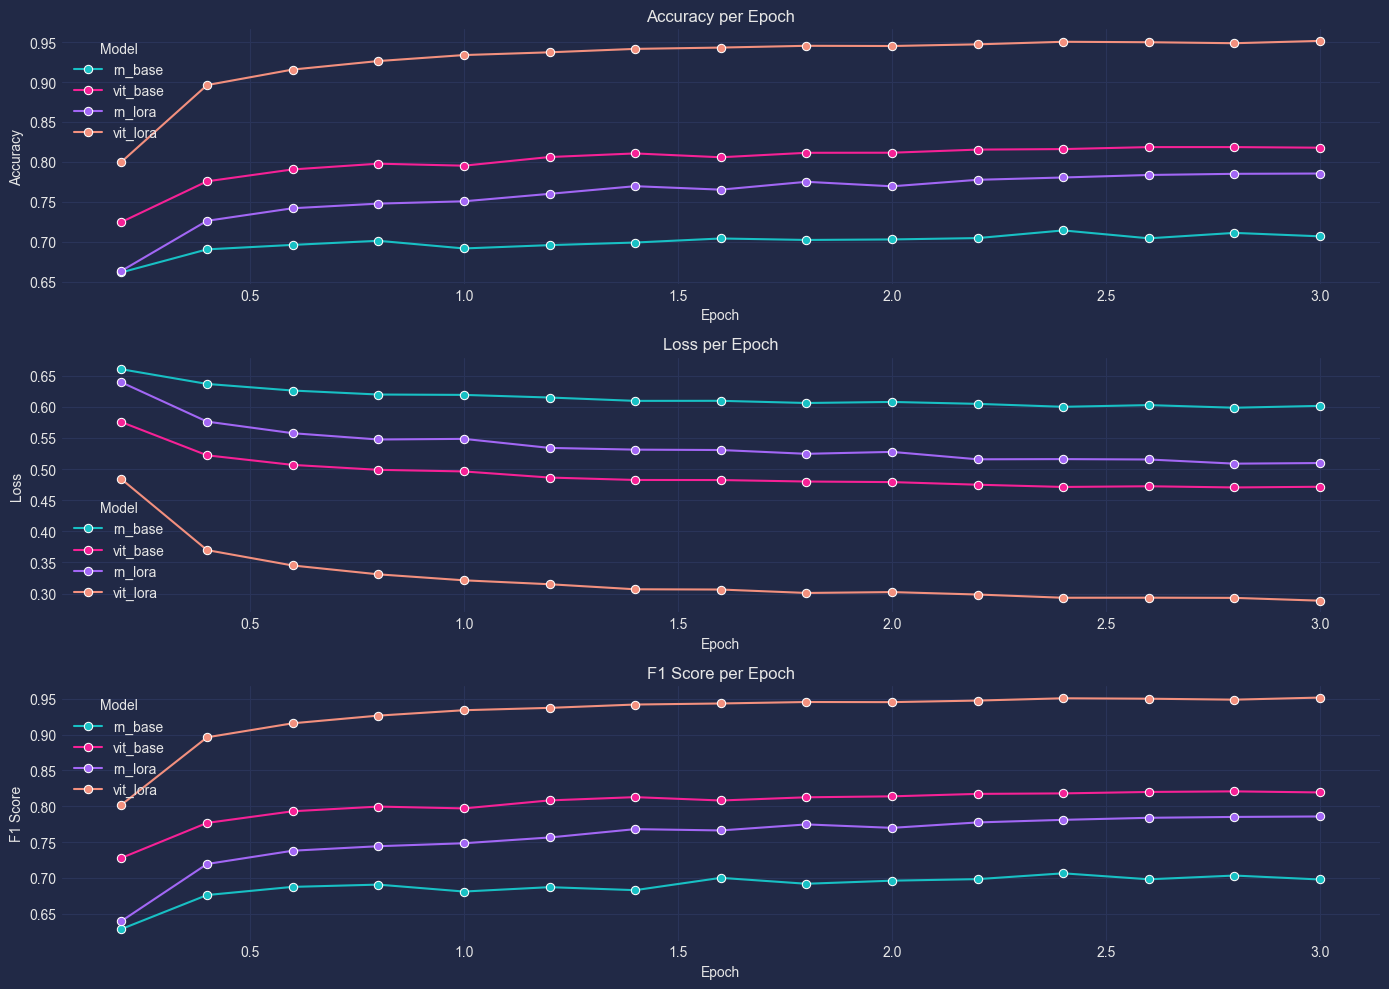

In [ ]:
# Initialize the visualizations
plt.figure(figsize=(14, 10))

# Subplot 1: Accuracy over epochs
plt.subplot(3, 1, 1)
sns.lineplot(data=data, x="Epoch", y="Accuracy", hue="Model", marker="o")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(title="Model")

# Subplot 2: Loss over epochs
plt.subplot(3, 1, 2)
sns.lineplot(data=data, x="Epoch", y="Loss", hue="Model", marker="o")
plt.title("Loss per Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(title="Model")

# Subplot 3: F1 Score(AUC/ROC proxy)
plt.subplot(3, 1, 3)
sns.lineplot(data=data, x="Epoch", y="F1_Score", hue="Model", marker="o")
plt.title("F1 Score per Epoch")
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.legend(title="Model")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## Validation statistic

### First evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-25000')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/12500 [00:00<?, ?it/s]

{'train_runtime': 0.0276, 'train_samples_per_second': 3617151.333, 'train_steps_per_second': 452143.917, 'train_loss': 0.0, 'epoch': 5.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71     10000
           1       0.72      0.70      0.71     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000


Confusion Matrix:
[[7213 2787]
 [2980 7020]]


In [ ]:
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-25000')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/12500 [00:00<?, ?it/s]

{'train_runtime': 0.027, 'train_samples_per_second': 3697767.747, 'train_steps_per_second': 462220.968, 'train_loss': 0.0, 'epoch': 5.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

        fake       0.79      0.82      0.81     10000
        real       0.81      0.79      0.80     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000


Confusion Matrix:
[[8209 1791]
 [2146 7854]]


In [ ]:
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-25000')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/12500 [00:00<?, ?it/s]

{'train_runtime': 0.0309, 'train_samples_per_second': 3234399.05, 'train_steps_per_second': 404299.881, 'train_loss': 0.0, 'epoch': 5.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

        fake       0.77      0.80      0.78     10000
        real       0.79      0.76      0.77     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000


Confusion Matrix:
[[8014 1986]
 [2448 7552]]


In [ ]:
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-25000')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/12500 [00:00<?, ?it/s]

{'train_runtime': 0.0219, 'train_samples_per_second': 4557638.979, 'train_steps_per_second': 569704.872, 'train_loss': 0.0, 'epoch': 5.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10000
           1       0.94      0.92      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000


Confusion Matrix:
[[9447  553]
 [ 789 9211]]


### Second evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-25000')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/25000 [00:00<?, ?it/s]

{'train_runtime': 0.0209, 'train_samples_per_second': 9549002.823, 'train_steps_per_second': 1193625.353, 'train_loss': 0.0, 'epoch': 10.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72     10000
           1       0.72      0.71      0.71     10000

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000


Confusion Matrix:
[[7215 2785]
 [2901 7099]]


In [ ]:
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-25000')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/25000 [00:00<?, ?it/s]

{'train_runtime': 0.015, 'train_samples_per_second': 13368512.646, 'train_steps_per_second': 1671064.081, 'train_loss': 0.0, 'epoch': 10.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82     10000
           1       0.82      0.80      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000


Confusion Matrix:
[[8279 1721]
 [2033 7967]]


In [ ]:
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-25000')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/25000 [00:00<?, ?it/s]

{'train_runtime': 0.014, 'train_samples_per_second': 14325053.365, 'train_steps_per_second': 1790631.671, 'train_loss': 0.0, 'epoch': 10.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     10000
           1       0.79      0.81      0.80     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000


Confusion Matrix:
[[7881 2119]
 [1866 8134]]


In [ ]:
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-25000')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/25000 [00:00<?, ?it/s]

{'train_runtime': 0.016, 'train_samples_per_second': 12534528.719, 'train_steps_per_second': 1566816.09, 'train_loss': 0.0, 'epoch': 10.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.95      0.94      0.94     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


Confusion Matrix:
[[9510  490]
 [ 605 9395]]


### Third evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/base',
    auto_find_batch_size=True,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

base_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/base',
    auto_find_batch_size=True,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_vit_training_args = TrainingArguments(
    output_dir='DummyModel/vit/lora',
    auto_find_batch_size=True,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

lora_rn_training_args = TrainingArguments(
    output_dir='DummyModel/rn/lora',
    auto_find_batch_size=True,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='logs',
    fp16='True',
    label_smoothing_factor=0.1
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/base/checkpoint-37500')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/37500 [00:00<?, ?it/s]

{'train_runtime': 0.0321, 'train_samples_per_second': 9332427.501, 'train_steps_per_second': 1166553.438, 'train_loss': 0.0, 'epoch': 15.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70     10000
           1       0.70      0.77      0.73     10000

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000


Confusion Matrix:
[[6712 3288]
 [2350 7650]]


In [ ]:
base_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/base/checkpoint-37500')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/37500 [00:00<?, ?it/s]

{'train_runtime': 0.0134, 'train_samples_per_second': 22372803.243, 'train_steps_per_second': 2796600.405, 'train_loss': 0.0, 'epoch': 15.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     10000
           1       0.83      0.80      0.82     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000


Confusion Matrix:
[[8357 1643]
 [1967 8033]]


In [ ]:
lora_rn_trainer.train(resume_from_checkpoint='DummyModel/rn/lora/checkpoint-37500')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/37500 [00:00<?, ?it/s]

{'train_runtime': 0.0219, 'train_samples_per_second': 13674105.629, 'train_steps_per_second': 1709263.204, 'train_loss': 0.0, 'epoch': 15.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.92      0.73     10000
           1       0.83      0.40      0.54     10000

    accuracy                           0.66     20000
   macro avg       0.72      0.66      0.63     20000
weighted avg       0.72      0.66      0.63     20000


Confusion Matrix:
[[9200  800]
 [6019 3981]]


In [ ]:
lora_vit_trainer.train(resume_from_checkpoint='DummyModel/vit/lora/checkpoint-37500')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(c

  0%|          | 0/37500 [00:00<?, ?it/s]

{'train_runtime': 0.017, 'train_samples_per_second': 17694498.819, 'train_steps_per_second': 2211812.352, 'train_loss': 0.0, 'epoch': 15.0}


  0%|          | 0/2500 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


Confusion Matrix:
[[9600  400]
 [ 594 9406]]


## 📊 Current Insight on Performance (until 3rd epoch)

### 🎓 During training:
-   **vit_lora** is the most accurate model, achieving the highest overall accuracy (0.9516), F1 Score (0.9519) and lowest loss (0.2887). But this model, at the same time, took the logest time to train and was the most computationally expensive.
- **rn_base** (Accuracy: 0.7067, Loss: 0.6015, F1 Score: 0.6976) performs the worst across all metrics, despite having the shortest train time and being least computationally expensive.
- Both **rn_lora** (Accuracy: 0.7854, Loss: 0.5097, F1 Score: 0.7857) and **vit_base** (Accuracy: 0.8178, Loss: 0.4716, F1 Score: 0.8193) are relatively stable but do not perform as well as **vit_lora** and as bad as **rn_base**.
- Both LoRA-injected models are performing better than their base respective models. ViT, in general, still beats ResNet with/without LoRA in terms of performance metrics, but is significantly more computational expensive and has much longer train time.

### 🧑‍💻 During evaluation:
-   The metrics from validation set indicate that the models are generalizing well to unseen data and not overfitting. All of the models also perform well in both classes and show no sign of bias.
-   **vit_lora** (Accuracy: 0.95) maintains the same metrics while training and is the best-performance model. Both **rn_base** (0.72) and **vit_base** (0.82) have somewhat okay accuracy, while **rn_lora** has the worst accuracy and shows signs of bias toward the negative class (0.66).
-   Overall, the models have strong consistency between training and validation, except the LoRA-injected ResNet model.

*These remarks are not the final version, further training iterations may help refine the performance of the models.*